In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import analysis
import utils
from sklearn import preprocessing
from scipy import stats
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [73]:
# Helper functions and Initialization
%matplotlib inline

def plotAllData(label, x = None, y = None):
    plt.title(label)
    plt.plot(x, y)
    plt.show()
    
def plotBitCoin(bitCoin, date, fieldName):
    plotAllData(fieldName, date, bitCoin[fieldName])
    
def plotAllFields(data, start = 1, dateClass = True):
    columns = data.columns
    if dateClass:
        date = pd.to_datetime(data[columns[0]])
    for i in range(start, len(columns)):
        print('Graph: ', columns[i])
        plt.title(columns[i])
        if dateClass:
            plt.plot(date, data[columns[i]])
        else:
            plt.plot(data[columns[i]])
        plt.show()
          
def plotCorrelation(data):
    corr = data.corr()
    fig, ax = plt.subplots(figsize=(10,10))  
    sns.heatmap(corr, 
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)
    
# Normalize data using Min Max scaling
def dataNormalization(nData):
    x = nData.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    scaledData = pd.DataFrame(x_scaled, columns = list(nData.columns))
    return scaledData

def analyzeCDFs(data, fields):
    plt.style.use('fivethirtyeight')
    for fld in fields:
        x, y = utils.plot_a(np.array(data[fld]))
        plt.plot(x, y)
        plt.title(fld)
        plt.savefig(fld, bbox_inches="tight")
        plt.clf()
        #plt.show(bbox_inches="tight")
        
def ConvertGamblingData(gambling, splittedDate = False):
    if splittedDate:
        newDF = gambling[gambling['Game Stream'] == 'Casino'][['Month','Year']]
    else:
        newDF = gambling[gambling['Game Stream'] == 'Casino'][['Month Year']]
    casino = np.array(gambling[gambling['Game Stream'] == 'Casino'][['Player Expenditure $']])
    egm = np.array(gambling[gambling['Game Stream'] == 'EGM'][['Player Expenditure $']])
    keno = np.array(gambling[gambling['Game Stream'] == 'Keno'][['Player Expenditure $']])
    lottery = np.array(gambling[gambling['Game Stream'] == 'Lottery'][['Player Expenditure $']])
    wagering = np.array(gambling[gambling['Game Stream'] == 'Wagering'][['Player Expenditure $']])
    # IGNORE CNP AS NO DATA IS AVAILABLE
    # cnp = np.array(gambling[gambling['Game Stream'] == 'CNP'][['Player Expenditure $']])

    # Add into DF
    newDF['Casino'] = casino
    newDF['EGM'] = egm
    newDF['Keno'] = keno
    newDF['Lottery'] = lottery
    newDF['Wagering'] = wagering
    # Re-Index
    newDF = newDF.reset_index(drop = True)
    return newDF

def plotD(fdata, gap, field):
    for year in [2011, 2012, 2013, 2014, 2015]:
        data = fdata[fdata['Year'] == year]
        vals = []
        i = 1
        while i <= 12:
            end = i + gap
            if end > 12:
                end = 12
            D1 = data[data['Month'] >= i]
            D2 = D1[D1['Month'] <= end][field].sum()
            #print(D2)
            i = i + gap
            vals.append(D2)
        plt.plot(vals)
    plt.title(field+ ' Gap :'+str(gap))
    plt.show()
    
def wald(X, Y):
    p1_hat = sum(X) / len(X)
    p2_hat = sum(Y) / len(Y)
    t_sum = 0
    for i in X:
        t_sum += (i - p1_hat)**2
    var_1 = t_sum / len(X)
    t_sum = 0
    for i in Y:
        t_sum += (i - p2_hat)**2
    var_2 = t_sum / len(Y)
    delta = abs(p1_hat - p2_hat)
    se_hat = np.sqrt((var_1/ len(X)) + (var_2 / len(Y)))
    w = abs((p1_hat - p2_hat) / se_hat)
    print(w)
    if w > 1.96:
        print('Reject Null')
    else:
        print('Accept Null')
    return w, delta, se_hat

def getPVal(X):
    return 2*stats.norm.cdf(-X)
    
def getConfidenceInterval(delta, se_hat, alpha = 1.96):
    lower_interval = delta - alpha * se_hat
    upper_interval = delta + alpha * se_hat
    return [lower_interval, upper_interval]

def runTests(X, Y, label):
    print('== Running Tests for {} =='.format(label))
    avgBTCYearly, delta, se_hat = wald(X, Y)
    print('P-Value: {}'.format(getPVal(avgBTCYearly)))
    cInterval = getConfidenceInterval(delta, se_hat)
    print('CI: {} '.format(cInterval))
    print('P-Val of P-Test: {}'.format(PermutationTest(X, Y)))
    
# Permutation Test
def PermutationTest(X, Y):
    tObs = abs(np.mean(X) - np.mean(Y))

    samples = np.append(X,Y)
    count = 0.0
    nFact = 100000 #(2 << (len(X) + len(Y)))
    for _ in range(nFact):
        tmp = np.random.permutation(samples)
        xP = tmp[:len(X)]
        yP = tmp[len(X):]
        tP = abs(np.mean(xP) - np.mean(yP))
        if tP > tObs:
            count += 1
    p = count / nFact
    return p

def averageData(data, groupByFields):
    # Take Monthly Average
    normalizedData = data.groupby(groupByFields).mean()
    normalizedData = normalizedData.reset_index()
    return normalizedData


In [3]:
# Bitcoin Price
bPrice = pd.read_csv('Data/bitcoin_price.csv')
dateData = pd.to_datetime(bPrice['Date'])

In [4]:
#plotAllFields(bPrice)

In [172]:
# Bit coin dataset
btc_dataset = pd.read_csv('Data/bitcoin_dataset.csv')
list(btc_dataset.columns)

['Date',
 'btc_market_price',
 'btc_total_bitcoins',
 'btc_market_cap',
 'btc_trade_volume',
 'btc_blocks_size',
 'btc_avg_block_size',
 'btc_n_orphaned_blocks',
 'btc_n_transactions_per_block',
 'btc_median_confirmation_time',
 'btc_hash_rate',
 'btc_difficulty',
 'btc_miners_revenue',
 'btc_transaction_fees',
 'btc_cost_per_transaction_percent',
 'btc_cost_per_transaction',
 'btc_n_unique_addresses',
 'btc_n_transactions',
 'btc_n_transactions_total',
 'btc_n_transactions_excluding_popular',
 'btc_n_transactions_excluding_chains_longer_than_100',
 'btc_output_volume',
 'btc_estimated_transaction_volume',
 'btc_estimated_transaction_volume_usd']

In [190]:
# Computer btc_per_month
entry = np.array(btc_dataset['btc_total_bitcoins'])
entry2 = entry
entry2 = np.insert(entry2, 0, 0)
entry = np.insert(entry, entry.shape[0], 0)
diff = entry - entry2
print(diff)
print(len(diff < 0))

[ 2.1107000e+06  9.5000000e+03  7.4000000e+03 ...  2.0250000e+03
  1.7625000e+03 -1.6876825e+07]
2921


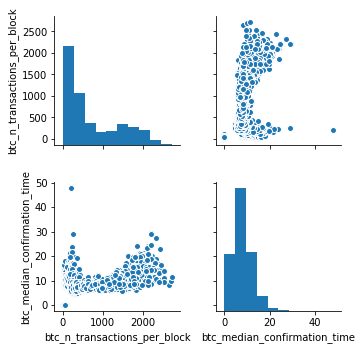

In [6]:
sns.pairplot(btc_dataset[btc_dataset.columns[[8, 9]]], palette='afmhot')

In [7]:
#sns.pairplot(hue = 'Year', palette='afmhot', data=bData)

In [8]:
#sns.factorplot(x = 'btc_hash_rate', y= 'btc_difficulty', hue = 'Year', data = bData)

('Graph: ', 'btc_market_price')


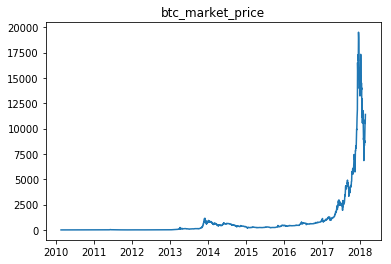

('Graph: ', 'btc_total_bitcoins')


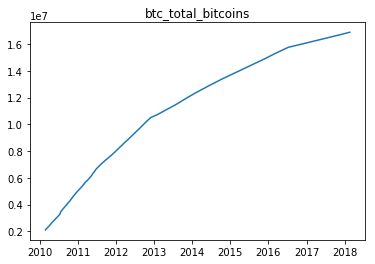

('Graph: ', 'btc_market_cap')


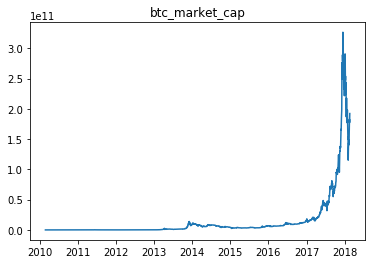

('Graph: ', 'btc_trade_volume')


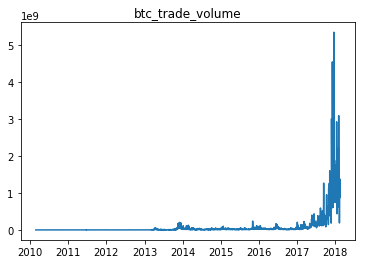

('Graph: ', 'btc_blocks_size')


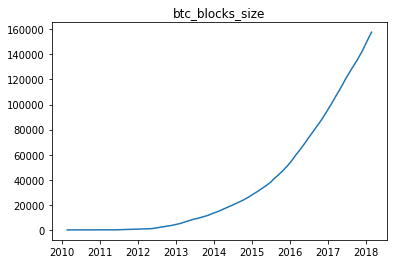

('Graph: ', 'btc_avg_block_size')


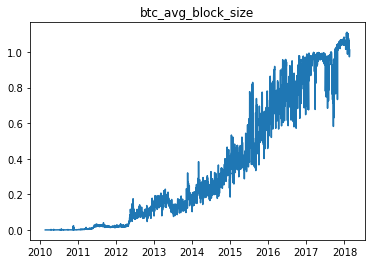

('Graph: ', 'btc_n_orphaned_blocks')


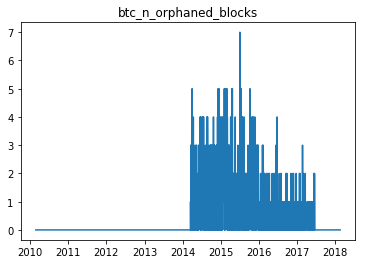

('Graph: ', 'btc_n_transactions_per_block')


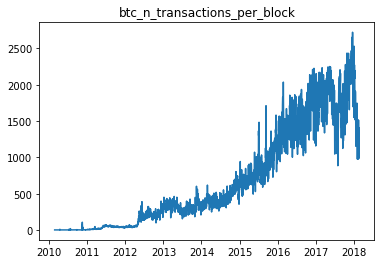

('Graph: ', 'btc_median_confirmation_time')


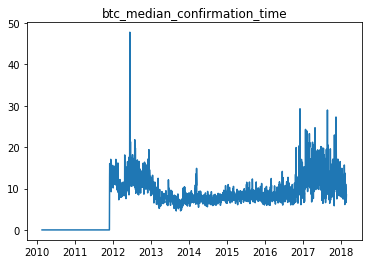

('Graph: ', 'btc_hash_rate')


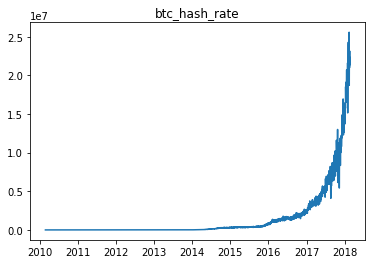

('Graph: ', 'btc_difficulty')


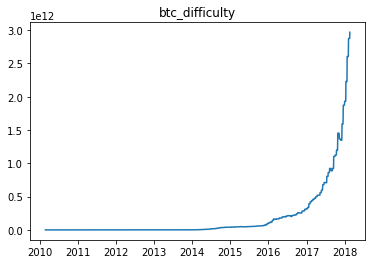

('Graph: ', 'btc_miners_revenue')


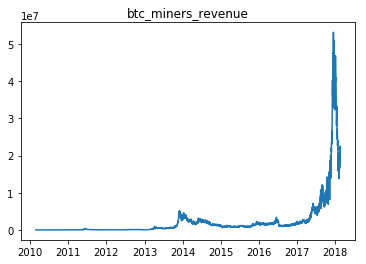

('Graph: ', 'btc_transaction_fees')


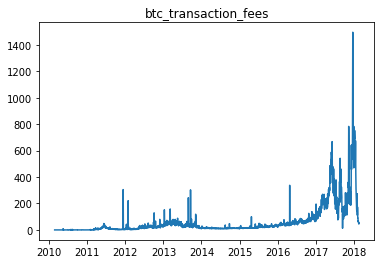

('Graph: ', 'btc_cost_per_transaction_percent')


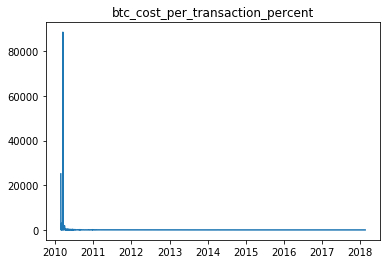

('Graph: ', 'btc_cost_per_transaction')


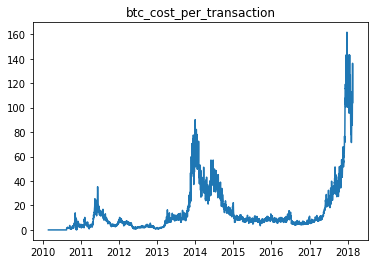

('Graph: ', 'btc_n_unique_addresses')


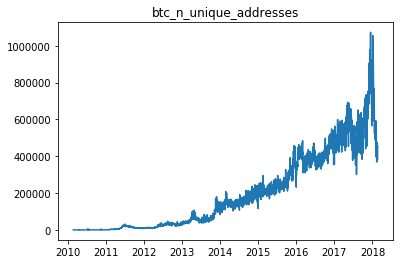

('Graph: ', 'btc_n_transactions')


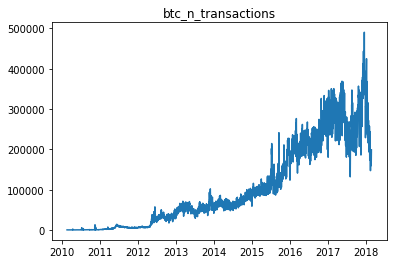

('Graph: ', 'btc_n_transactions_total')


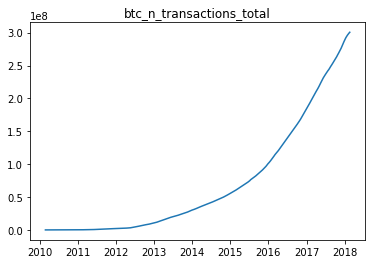

('Graph: ', 'btc_n_transactions_excluding_popular')


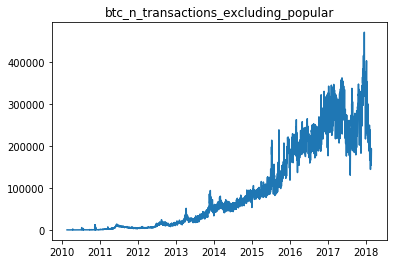

('Graph: ', 'btc_n_transactions_excluding_chains_longer_than_100')


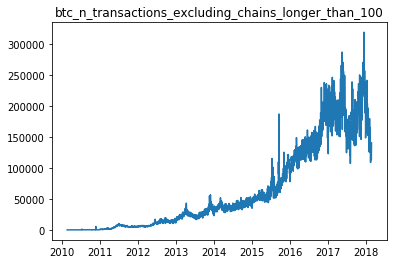

('Graph: ', 'btc_output_volume')


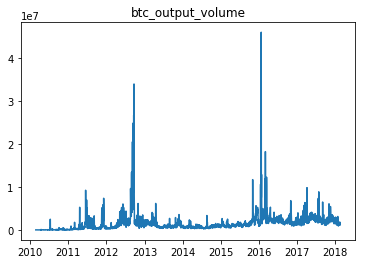

('Graph: ', 'btc_estimated_transaction_volume')


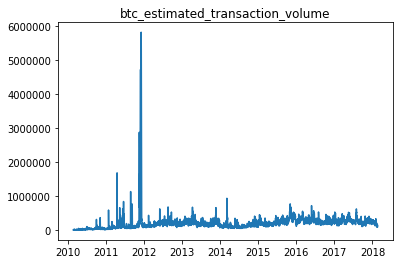

('Graph: ', 'btc_estimated_transaction_volume_usd')


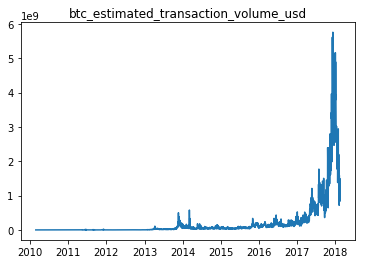

In [9]:
plotAllFields(btc_dataset)

In [10]:
# bitcoin_cash_price.csv
bData = pd.read_csv('Data/bitcoin_cash_price.csv')
print('Columns:', bData.columns)

('Columns:', Index([u'Date', u'Open', u'High', u'Low', u'Close', u'Volume', u'Market Cap'], dtype='object'))


In [11]:
# get Year data
bData['NDate'] = pd.to_datetime(bData['Date'])
bData['Year'] = bData['NDate'].apply(lambda x: x.year)
#bData['Year'] = date

('Graph: ', 'Open')


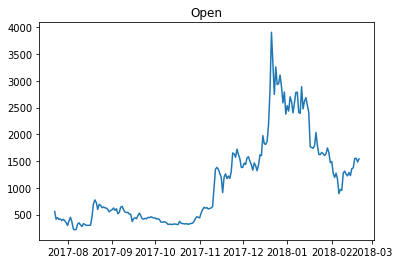

('Graph: ', 'High')


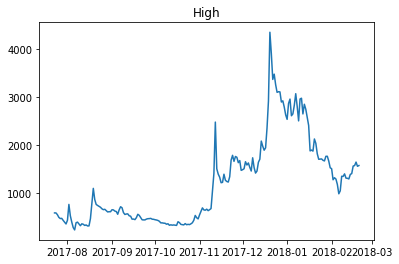

('Graph: ', 'Low')


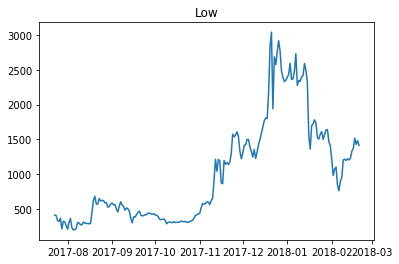

('Graph: ', 'Close')


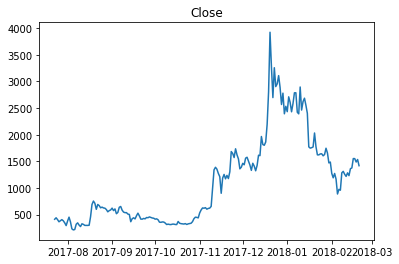

('Graph: ', 'Volume')


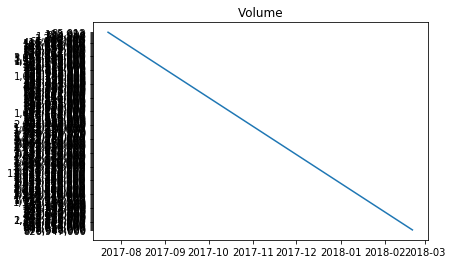

('Graph: ', 'Market Cap')


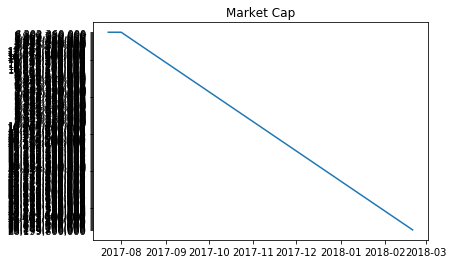

('Graph: ', 'NDate')


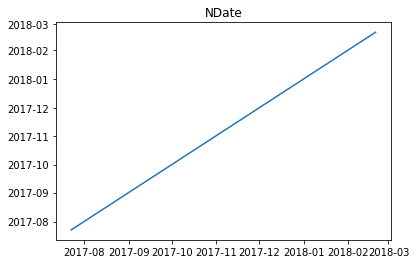

('Graph: ', 'Year')


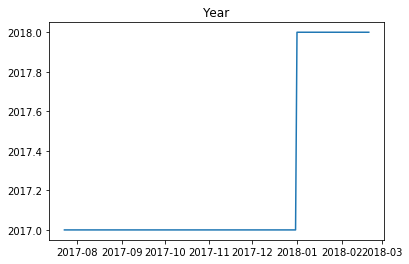

In [12]:
plotAllFields(bData)

/home/bhushan/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


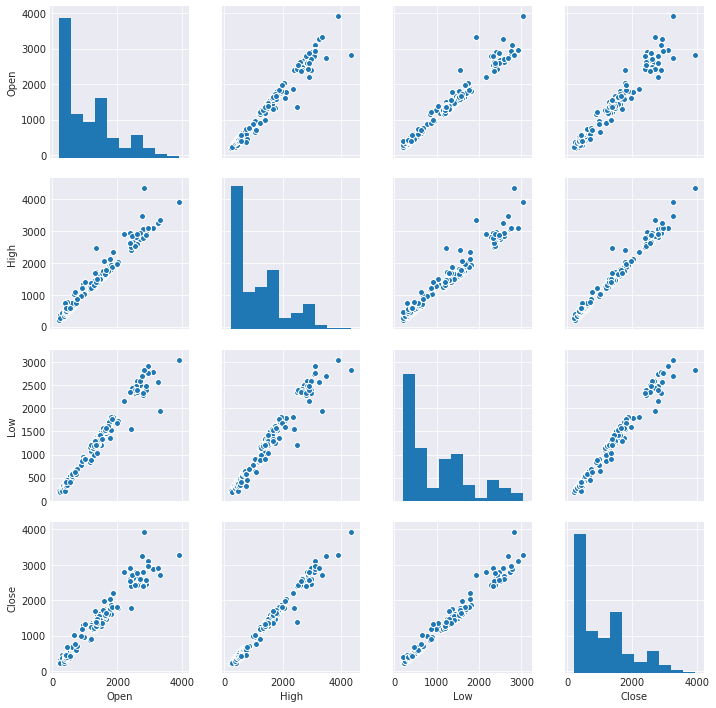

In [13]:
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
sns.pairplot(bData[bData.columns[[1,2,3,4,5,6]]], palette=sns.color_palette("Reds_d", n_colors=7, desat=1)) #'afmhot')

### Convert bit-coin data month wise

In [14]:
# Using BTC DATASET
btc_dataset = pd.read_csv('Data/bitcoin_dataset.csv')
date = pd.to_datetime(btc_dataset['Date'])
btc_dataset['Day'] = date.dt.day
btc_dataset['Month'] = date.dt.month
btc_dataset['Year'] = date.dt.year

nData = btc_dataset #[['Month', 'Year', 'btc_market_price', 'btc_trade_volume', 'btc_n_transactions_total']]
nD = nData[nData['Year'] >= 2013]

# Take Monthly Average
mAvg_BTC = nD.groupby(['Year', 'Month']).mean()
mAvg_BTC = mAvg_BTC.reset_index()

In [15]:
mAvg_BTC = mAvg_BTC[:52]
mAvg_BTC

Year  Month  btc_market_price  btc_total_bitcoins  btc_market_cap  \
0   2013      1         15.847793        1.067012e+07    1.691648e+08   
1   2013      2         26.148923        1.078290e+07    2.820874e+08   
2   2013      3         57.670729        1.090784e+07    6.297676e+08   
3   2013      4        130.850051        1.103919e+07    1.444396e+09   
4   2013      5        120.252263        1.116175e+07    1.342483e+09   
5   2013      6        107.988127        1.129280e+07    1.219255e+09   
6   2013      7         90.097818        1.142221e+07    1.029389e+09   
7   2013      8        107.626459        1.156230e+07    1.244630e+09   
8   2013      9        125.171000        1.170625e+07    1.465266e+09   
9   2013     10        153.181935        1.185271e+07    1.816994e+09   
10  2013     11        538.100000        1.199662e+07    6.465440e+09   
11  2013     12        790.453871        1.213190e+07    9.585202e+09   
12  2014      1        821.143871        1.227011e+07    1.007514e+10   
13  2014      2        666.894286        1.239886e+07    8.265870e+09   
14  2014      3        594.324516        1.252276e+07    7.440960e+09   
15  2014      4        461.246667        1.265214e+07    5.836038e+09   
16  2014      5        487.046774        1.277712e+07    6.224989e+09   
17  2014      6        613.369333        1.290326e+07    7.913547e+09   
18  2014      7        619.258710        1.302640e+07    8.066116e+09   
19  2014      8        537.705484        1.314908e+07    7.069022e+09   
20  2014      9        445.007333        1.327390e+07    5.905783e+09   
21  2014     10        363.517419        1.339046e+07    4.867686e+09   
22  2014     11        366.218333        1.350545e+07    4.946343e+09   
23  2014     12        343.123226        1.361493e+07    4.670904e+09   
24  2015      1        249.274839        1.373022e+07    3.421960e+09   
25  2015      2        233.739286        1.383886e+07    3.234941e+09   
26  2015      3        268.133548        1.394755e+07    3.739481e+09   
27  2015      4        234.606000        1.405837e+07    3.297901e+09   
28  2015      5        237.142258        1.416752e+07    3.359690e+09   
29  2015      6        237.276333        1.427803e+07    3.388146e+09   
30  2015      7        279.886774        1.438999e+07    4.027833e+09   
31  2015      8        252.816129        1.450404e+07    3.666164e+09   
32  2015      9        233.819000        1.461784e+07    3.417928e+09   
33  2015     10        265.384516        1.472993e+07    3.909854e+09   
34  2015     11        349.386000        1.484527e+07    5.186344e+09   
35  2015     12        422.022258        1.496753e+07    6.317406e+09   
36  2016      1        410.954194        1.509007e+07    6.200581e+09   
37  2016      2        402.526552        1.521231e+07    6.124100e+09   
38  2016      3        415.502258        1.532323e+07    6.366825e+09   
39  2016      4        434.075333        1.543725e+07    6.698092e+09   
40  2016      5        460.761290        1.555180e+07    7.166094e+09   
41  2016      6        640.389954        1.566401e+07    1.006520e+10   
42  2016      7        661.036602        1.576084e+07    1.043479e+10   
43  2016      8        579.744405        1.581894e+07    9.201481e+09   
44  2016      9        607.146550        1.587584e+07    9.661413e+09   
45  2016     10        642.163788        1.593296e+07    1.026940e+10   
46  2016     11        724.360973        1.598942e+07    1.160023e+10   
47  2016     12        822.463950        1.604708e+07    1.322795e+10   
48  2017      1        909.749629        1.610701e+07    1.468449e+10   
49  2017      2       1063.003843        1.616441e+07    1.720776e+10   
50  2017      3       1129.199654        1.621978e+07    1.828479e+10   
51  2017      4       1221.494590        1.627660e+07    2.019389e+10   

    btc_trade_volume  btc_blocks_size  btc_avg_block_size  \
0       8.785402e+05      4560.064516            0.146898   
1       1.65

In [16]:
# uMonths = np.unique(np.array(btc_dataset[['Month']]))
# uYears = np.unique(np.array(btc_dataset[['Year']]))
# print(uMonths)
# print(uYears)

# nData = btc_dataset[['Month', 'Year', 'btc_market_price', 'btc_trade_volume', 'btc_n_transactions_total']]
# nData = nData[nData['Year'] >= 2013]
# #for year in uYears:
# #    for month in uMonths:
# print(nData[:5])     

In [17]:
# mD = nData[nData['Month'] == 2]
# nD = mD[mD['Year'] == 2014]
# print(nD['btc_market_price'].mean())
# print(nD['btc_trade_volume'].mean())
# print(nD['btc_n_transactions_total'].mean())
# #nD[['btc_market_price', 'btc_trade_volume', 'btc_n_transcations_total']].mean()

### GAMBLING ANALYSIS

In [18]:
gambling = pd.read_csv('Data/Casino/20170616_OLGR_All-gambling-data.csv')
#dateData = pd.to_datetime(bPrice['Date'])

In [19]:
#print(gambling[-300:])

In [20]:
gambling.columns

Index([u'Month Year', u'Game Stream', u'Player Expenditure $'], dtype='object')

In [21]:
cols = list(gambling.columns.values)
vals = gambling['Game Stream'].unique()
print(vals)

['Casino' 'EGM' 'Keno' 'Lottery' 'Wagering' 'CNP']


In [22]:
newDF = ConvertGamblingData(gambling)
print(newDF.shape)

(154, 6)


In [23]:
gamblingData = newDF[:][-52:]
gamblingData = gamblingData.reset_index(drop = True)

In [24]:
# tData = newDF[:][:]
# print(newDF[:][-52:])
gamblingData.shape

(52, 6)

('Graph: ', 'Casino')


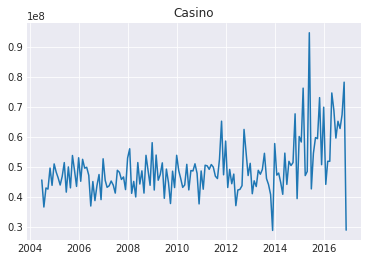

('Graph: ', 'EGM')


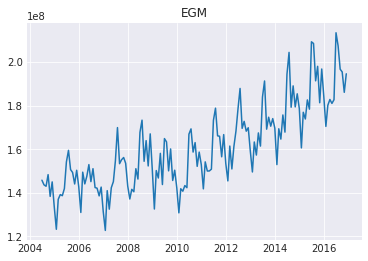

('Graph: ', 'Keno')


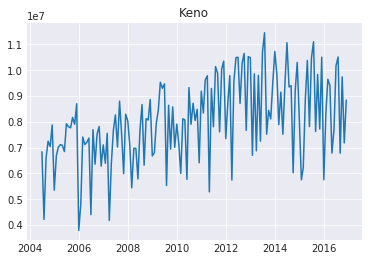

('Graph: ', 'Lottery')


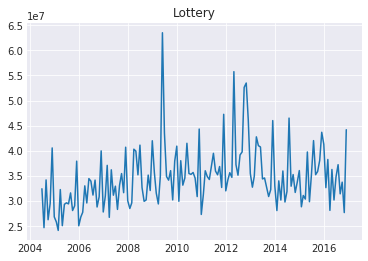

('Graph: ', 'Wagering')


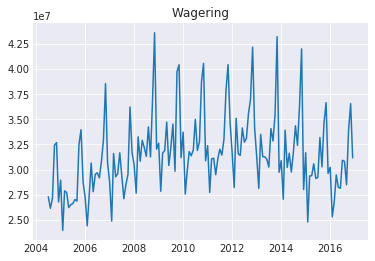

In [25]:
plotAllFields(newDF[:150], start = 1, dateClass = True)

In [26]:
mAvg_BTC = mAvg_BTC.reset_index(drop = True)
print(mAvg_BTC.columns)
print(gamblingData.columns)

Index([u'Year', u'Month', u'btc_market_price', u'btc_total_bitcoins',
       u'btc_market_cap', u'btc_trade_volume', u'btc_blocks_size',
       u'btc_avg_block_size', u'btc_n_orphaned_blocks',
       u'btc_n_transactions_per_block', u'btc_median_confirmation_time',
       u'btc_hash_rate', u'btc_difficulty', u'btc_miners_revenue',
       u'btc_transaction_fees', u'btc_cost_per_transaction_percent',
       u'btc_cost_per_transaction', u'btc_n_unique_addresses',
       u'btc_n_transactions', u'btc_n_transactions_total',
       u'btc_n_transactions_excluding_popular',
       u'btc_n_transactions_excluding_chains_longer_than_100',
       u'btc_output_volume', u'btc_estimated_transaction_volume',
       u'btc_estimated_transaction_volume_usd', u'Day'],
      dtype='object')
Index([u'Month Year', u'Casino', u'EGM', u'Keno', u'Lottery', u'Wagering'], dtype='object')


In [27]:
mAvg_BTC[['Casino', 'EGM', 'Keno', 'Lottery', 'Wagering']] = gamblingData[['Casino', 'EGM', 'Keno', 'Lottery', 'Wagering']] 
mAvg_BTC[:2]

Year  Month  btc_market_price  btc_total_bitcoins  btc_market_cap  \
0  2013      1         15.847793        1.067012e+07    1.691648e+08   
1  2013      2         26.148923        1.078290e+07    2.820874e+08   

   btc_trade_volume  btc_blocks_size  btc_avg_block_size  \
0      8.785402e+05      4560.064516            0.146898   
1      1.654326e+06      5242.428571            0.156744   

   btc_n_orphaned_blocks  btc_n_transactions_per_block     ...       \
0                    0.0                     337.83871     ...        
1                    0.0                     350.00000     ...        

   btc_n_transactions_excluding_chains_longer_than_100  btc_output_volume  \
0                                       18436.903226         1.667659e+06   
1                                       21900.178571         1.518587e+06   

   btc_estimated_transaction_volume  btc_estimated_transaction_volume_usd  \
0                     226015.000000                          3.682840e+06   
1                     254553.107143                          6.687705e+06   

    Day       Casino           EGM        Keno      Lottery     Wagering  
0  16.0  51217299.27  1.590335e+08  10488684.2  35467940.76  31288258.62  
1  14.5  41079943.42  1.495322e+08   6700519.4  32766663.43  28129772.22  

[2 rows x 31 columns]

### Analysis
gamblingData : Monthly averaged data
mAvg_BTC: BitCoind data averaged monthly

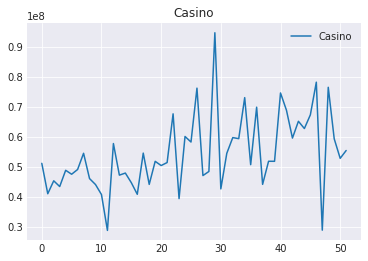

In [28]:
plt.title('Casino')
#plt.plot(mAvg_BTC['btc_market_price'])
#plt.scatter(mAvg_BTC['btc_market_price'], gamblingData['EGM'])
#plt.scatter(mAvg_BTC['btc_market_price'], gamblingData['Keno'])
#plt.scatter(mAvg_BTC['btc_market_price'], gamblingData['Lottery'])
#plt.scatter(mAvg_BTC['btc_market_price'], gamblingData['Wagering'])
plt.plot(mAvg_BTC['Casino'])
#plt.plot(mAvg_BTC['EGM'])
plt.legend()
plt.show()

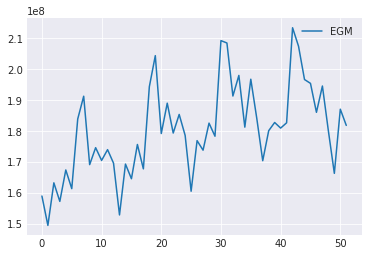

In [29]:
plt.plot(mAvg_BTC['EGM'])
plt.legend()
plt.show()

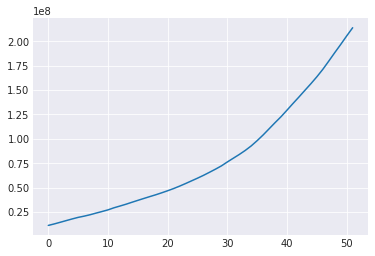

In [30]:
plt.plot(mAvg_BTC['btc_n_transactions_total'])

In [31]:
# print(mAvg_BTC.columns)
# scaledData = mAvg_BTC
# scaledData['btc_market_price'] /= max(scaledData['btc_market_price']) 
# scaledData['btc_trade_volume'] /= max(scaledData['btc_trade_volume']) 
# scaledData['btc_n_transactions_total'] /= max(scaledData['btc_n_transactions_total']) 
# scaledData['Casino'] /= max(scaledData['Casino']) 
# scaledData['EGM'] /= max(scaledData['EGM']) 
# scaledData['Keno'] /= max(scaledData['Keno']) 
# scaledData['Lottery'] /= max(scaledData['Lottery']) 
# scaledData['Wagering'] /= max(scaledData['Wagering'])
# corr = scaledData.corr()
# sns.heatmap(corr, 
#             xticklabels=corr.columns.values,
#             yticklabels=corr.columns.values)

In [32]:
from sklearn import preprocessing

x = mAvg_BTC.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaledData = pd.DataFrame(x_scaled, columns = list(mAvg_BTC.columns))

corr = scaledData.corr()

In [33]:
# np.min(scaledData['btc_n_transactions_total'])

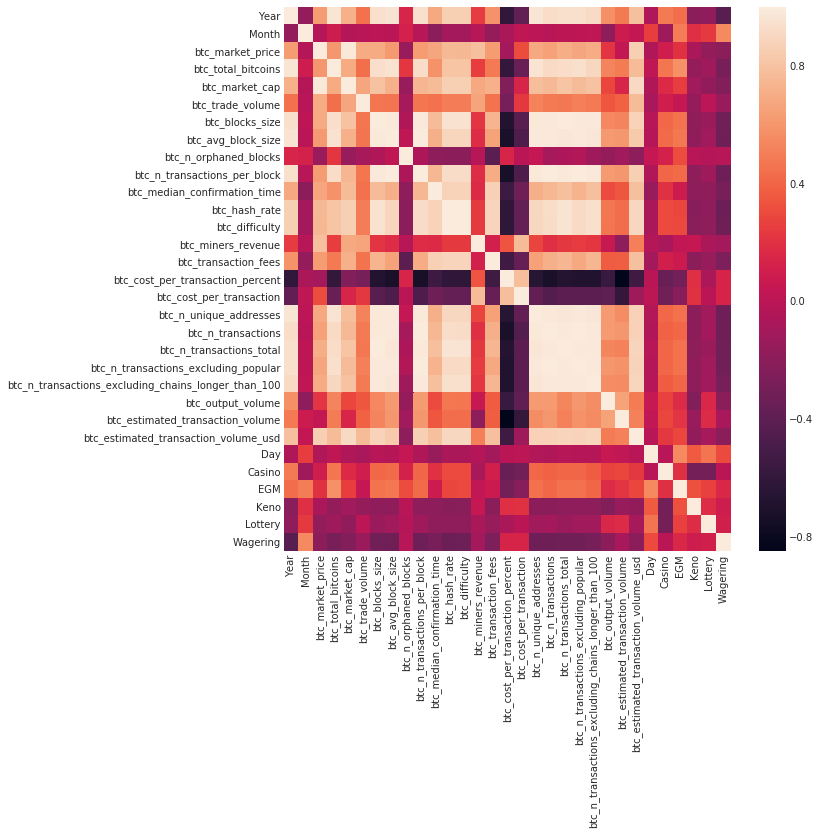

In [34]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

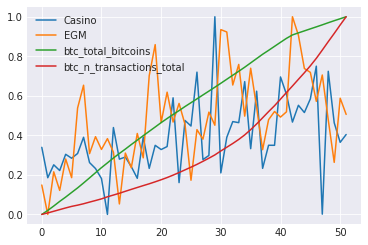

In [35]:
plt.plot(scaledData['Casino'])
plt.plot(scaledData['EGM'])
plt.plot(scaledData['btc_total_bitcoins'])
plt.plot(scaledData['btc_n_transactions_total'])
plt.legend()

### Task 1: Generate Single data for further use

In [36]:
# Using BTC DATASET
btc_dataset = pd.read_csv('Data/bitcoin_dataset.csv')
date = pd.to_datetime(btc_dataset['Date'])
btc_dataset['Day'] = date.dt.day
btc_dataset['Month'] = date.dt.month
btc_dataset['Year'] = date.dt.year

nD = btc_dataset #[['Month', 'Year', 'btc_market_price', 'btc_trade_volume', 'btc_n_transactions_total']]
# nD = nData[nData['Year'] >= 2013]

# Take Monthly Average
mAvg_BTC = nD.groupby(['Year', 'Month']).mean()
mAvg_BTC = mAvg_BTC.reset_index()

In [37]:
mAvg_BTC[:][:2]

Year  Month  btc_market_price  btc_total_bitcoins  btc_market_cap  \
0  2010      2               0.0        2.132033e+06             0.0   
1  2010      3               0.0        2.282116e+06             0.0   

   btc_trade_volume  btc_blocks_size  btc_avg_block_size  \
0               0.0              0.0            0.000260   
1               0.0              0.0            0.000268   

   btc_n_orphaned_blocks  btc_n_transactions_per_block  ...   \
0                    0.0                           1.0  ...    
1                    0.0                           1.0  ...    

   btc_cost_per_transaction  btc_n_unique_addresses  btc_n_transactions  \
0                       0.0              185.666667          185.833333   
1                       0.0              172.580645          173.548387   

   btc_n_transactions_total  btc_n_transactions_excluding_popular  \
0              43050.500000                            185.833333   
1              46141.645161                            173.548387   

   btc_n_transactions_excluding_chains_longer_than_100  btc_output_volume  \
0                                         185.833333         14558.166667   
1                                         173.548387         13247.790000   

   btc_estimated_transaction_volume  btc_estimated_transaction_volume_usd  \
0                       4152.000000                                   0.0   
1                       4831.645161                                   0.0   

    Day  
0  25.5  
1  16.0  

[2 rows x 26 columns]

In [38]:
btcData = mAvg_BTC[:][:87]

In [39]:
gambling[:][:3]

Month Year Game Stream  Player Expenditure $
0  July 2004      Casino          4.566213e+07
1  July 2004         EGM          1.457668e+08
2  July 2004        Keno          6.836927e+06

In [61]:
# HAVE ALREADY GENERATED DATA 
# # Get Gambling data - 
# gambling = pd.read_csv('Data/Casino/updated_gambling.csv')  #20170616_OLGR_All-gambling-data.csv')
# gambling = ConvertGamblingData(gambling, splittedDate = True)
# gambling.to_csv('./Data/Casino/gamble.csv')

# reqEntries = gambling.shape[0] - btcData.shape[0]
# dim = btcData.shape[1]
# tmp = pd.DataFrame(np.zeros((reqEntries, dim)), columns = list(btcData.columns))
# fullData = tmp.append(btcData)
# fullData = fullData.reset_index(drop = True)
# fullData[['Casino', 'EGM', 'Keno', 'Lottery', 'Wagering', 'Month', 'Year']] = gambling[['Casino', 'EGM', 'Keno', 'Lottery', 'Wagering', 'Month', 'Year']] 
# fullData.to_csv('./Data/Casino/ProcessedDataAll_WRITING.csv', index = False)

# UNCOMMENT ABOVE AND COMMENT BELOW TO RE-GENERATE
fullData = pd.read_csv('./Data/Casino/ProcessedDataAll.csv')

In [62]:
fullData['Year'][-2:]

152    2017
153    2017
Name: Year, dtype: int64

In [63]:
print(gambling.shape, btcData.shape)

((771, 3), (87, 26))


### 1. Normalized the data

In [64]:
nData = averageData(fullData, ['Year', 'Month'])
nData[:][:2]

Year  Month  btc_market_price  btc_total_bitcoins  btc_market_cap  \
0  2004      7               0.0                 0.0             0.0   
1  2004      8               0.0                 0.0             0.0   

   btc_trade_volume  btc_blocks_size  btc_avg_block_size  \
0               0.0              0.0                 0.0   
1               0.0              0.0                 0.0   

   btc_n_orphaned_blocks  btc_n_transactions_per_block      ...        \
0                    0.0                           0.0      ...         
1                    0.0                           0.0      ...         

   btc_output_volume  btc_estimated_transaction_volume  \
0                0.0                               0.0   
1                0.0                               0.0   

   btc_estimated_transaction_volume_usd  Day       Casino           EGM  \
0                                   0.0  0.0  45662132.51  1.457668e+08   
1                                   0.0  0.0  36652961.84  1.436279e+08   

         Keno      Lottery     Wagering  btc_per_month  
0  6836926.58  32451660.78  27298552.41            0.0  
1  4215418.49  24712127.10  26147748.54            0.0  

[2 rows x 32 columns]

('Graph: ', 'btc_market_price')


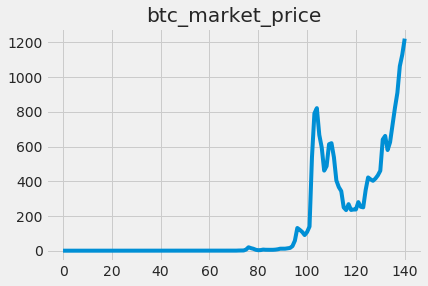

('Graph: ', 'btc_total_bitcoins')


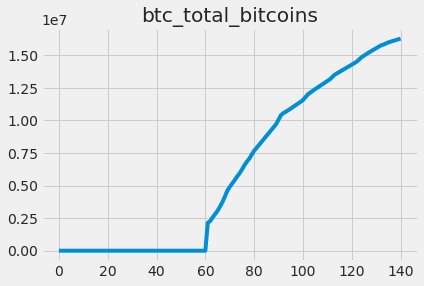

('Graph: ', 'btc_market_cap')


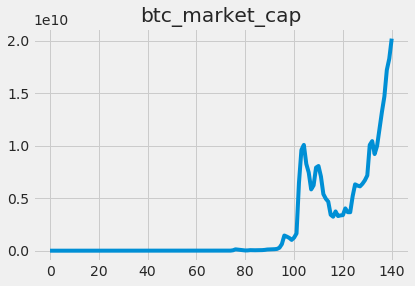

('Graph: ', 'btc_trade_volume')


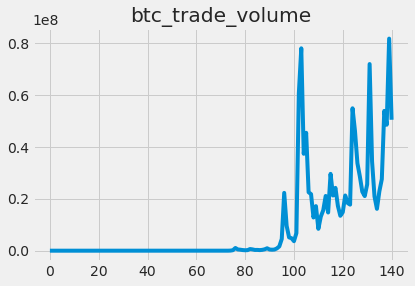

('Graph: ', 'btc_blocks_size')


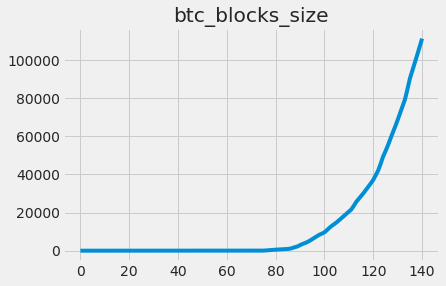

('Graph: ', 'btc_avg_block_size')


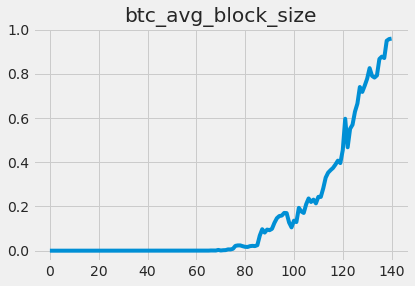

('Graph: ', 'btc_n_orphaned_blocks')


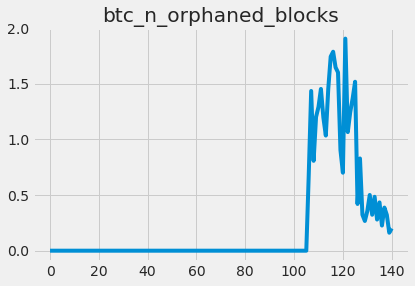

('Graph: ', 'btc_n_transactions_per_block')


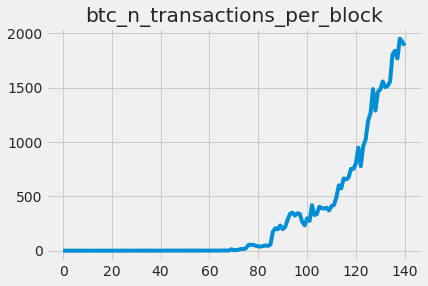

('Graph: ', 'btc_median_confirmation_time')


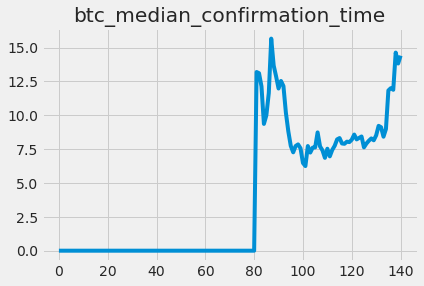

('Graph: ', 'btc_hash_rate')


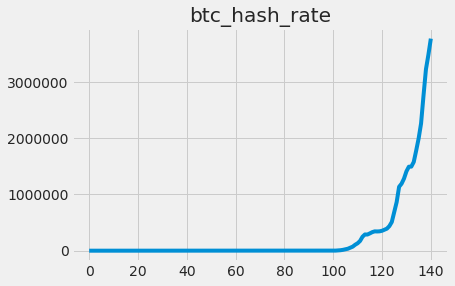

('Graph: ', 'btc_difficulty')


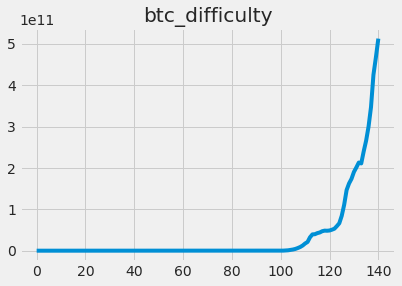

('Graph: ', 'btc_miners_revenue')


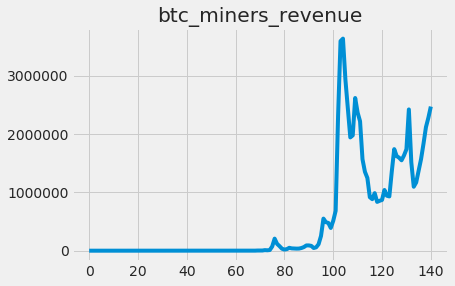

('Graph: ', 'btc_transaction_fees')


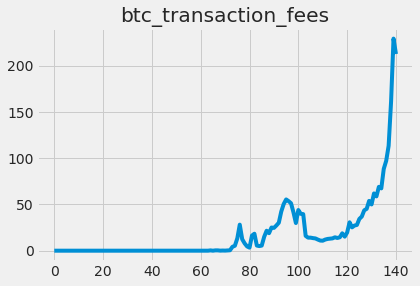

('Graph: ', 'btc_cost_per_transaction_percent')


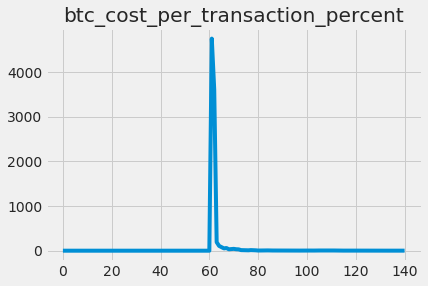

('Graph: ', 'btc_cost_per_transaction')


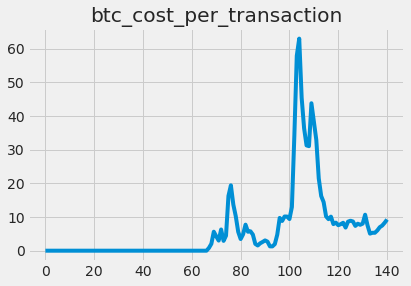

('Graph: ', 'btc_n_unique_addresses')


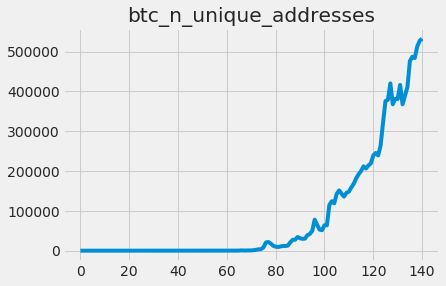

('Graph: ', 'btc_n_transactions')


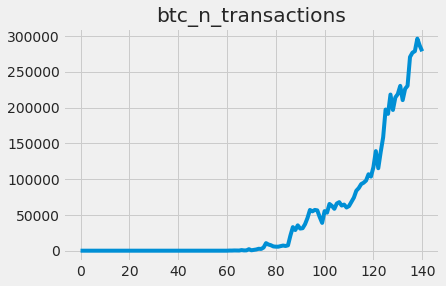

('Graph: ', 'btc_n_transactions_total')


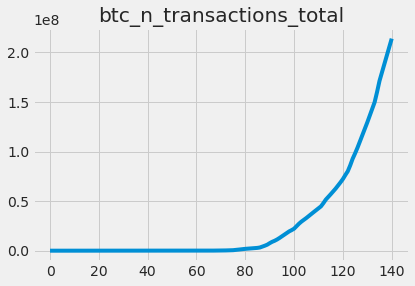

('Graph: ', 'btc_n_transactions_excluding_popular')


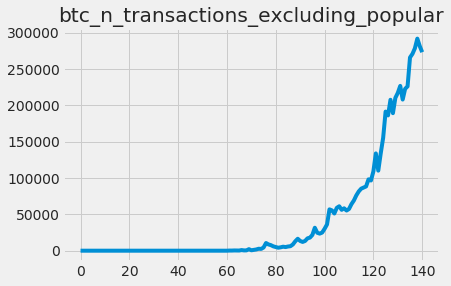

('Graph: ', 'btc_n_transactions_excluding_chains_longer_than_100')


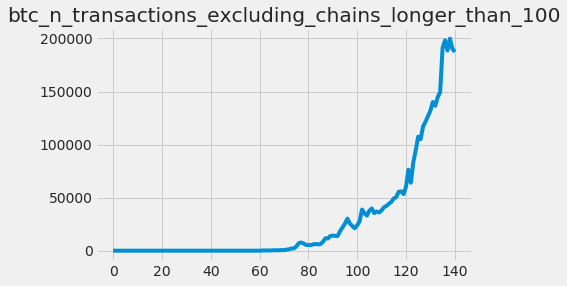

('Graph: ', 'btc_output_volume')


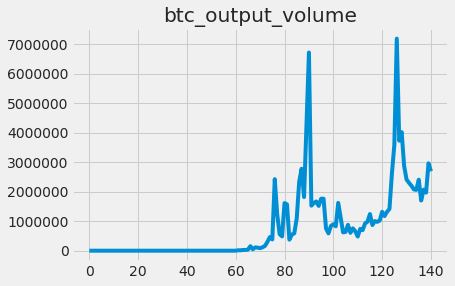

('Graph: ', 'btc_estimated_transaction_volume')


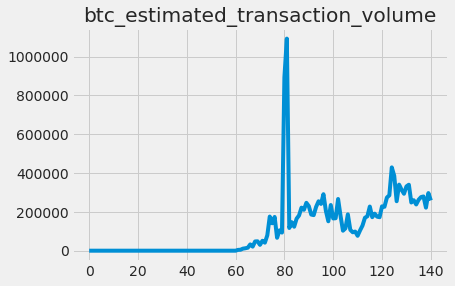

('Graph: ', 'btc_estimated_transaction_volume_usd')


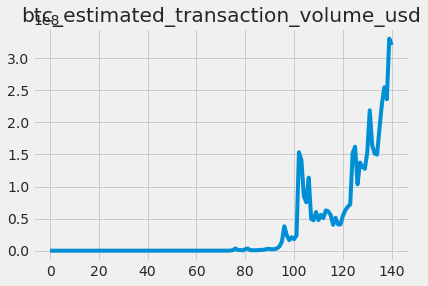

('Graph: ', 'Day')


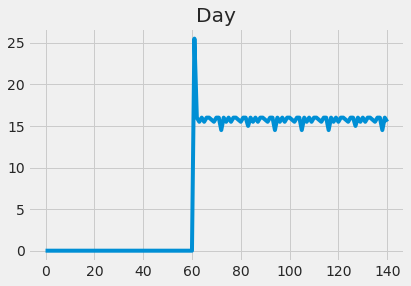

('Graph: ', 'Casino')


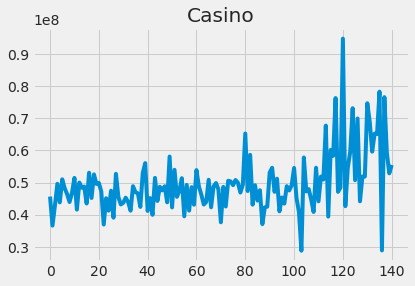

('Graph: ', 'EGM')


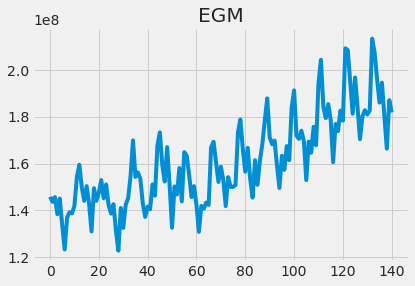

('Graph: ', 'Keno')


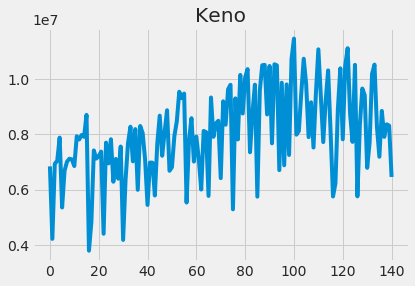

('Graph: ', 'Lottery')


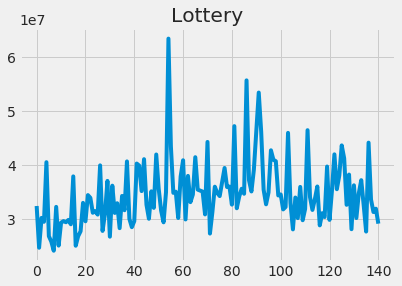

('Graph: ', 'Wagering')


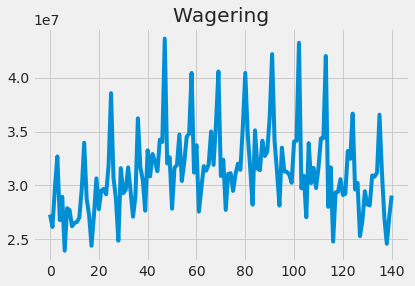

('Graph: ', 'btc_per_month')


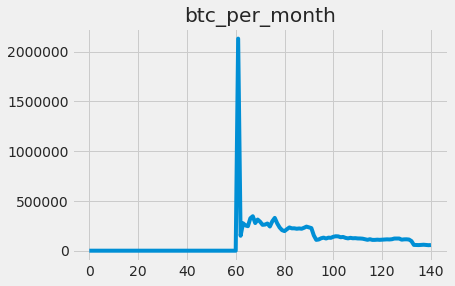

In [65]:
plotAllFields(nData, start = 2, dateClass = False)

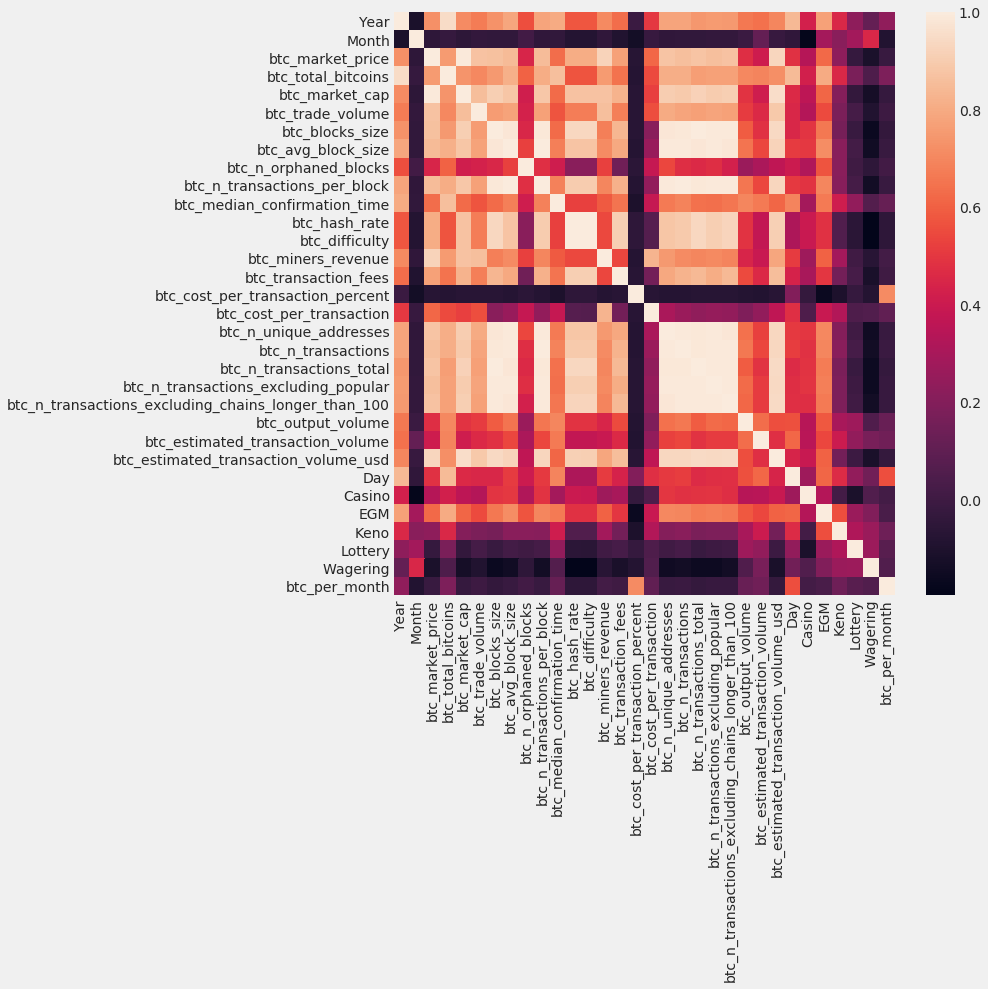

In [66]:
scaledData = dataNormalization(nData)
plotCorrelation(scaledData)

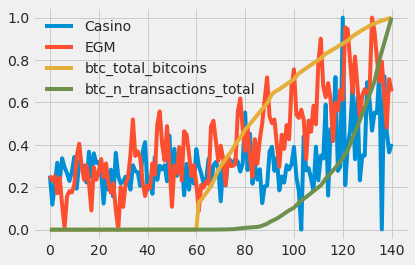

In [67]:
plt.plot(scaledData['Casino'])
plt.plot(scaledData['EGM'])
plt.plot(scaledData['btc_total_bitcoins'])
plt.plot(scaledData['btc_n_transactions_total'])
plt.legend()

### CDF of data

In [74]:
#scaledData[:1]
analyzeCDFs(scaledData, ['Casino', 'EGM', 'btc_total_bitcoins', 'btc_n_transactions_total', 'btc_per_month'])

<Figure size 432x288 with 0 Axes>

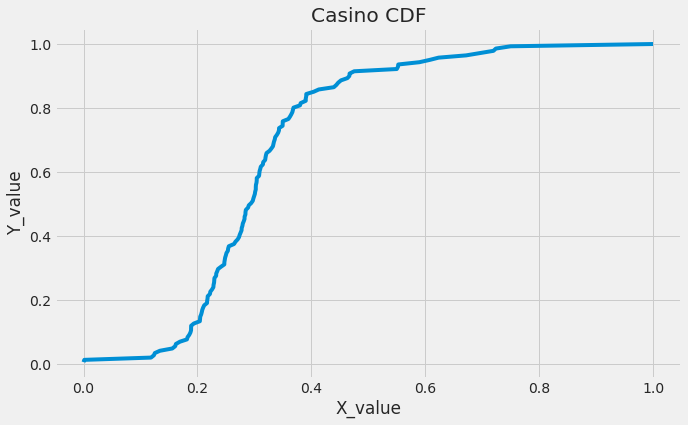

In [210]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
x, y = utils.plot_a(np.array(scaledData['Casino']))
plt.plot(x, y)
plt.xlabel('X_value')
plt.ylabel('Y_value')
plt.title('Casino CDF')
plt.savefig('cdf_casino', bbox_inches="tight")
#plt.clf()
plt.show()

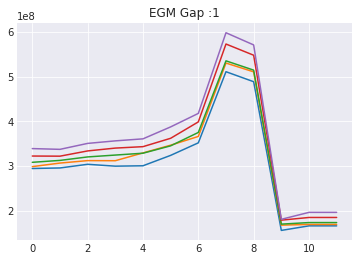

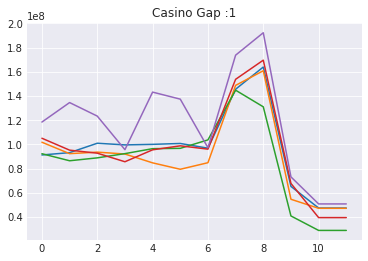

In [153]:
plotD(fullData, 1, 'EGM')
plotD(fullData, 1, 'Casino')

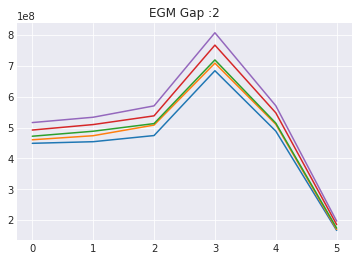

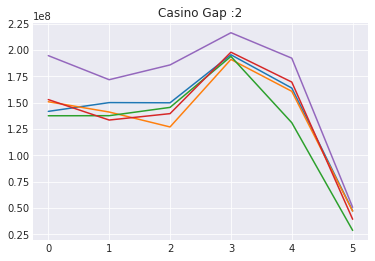

In [154]:
plotD(fullData, 2, 'EGM')
plotD(fullData, 2, 'Casino')

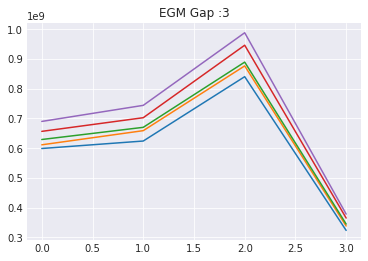

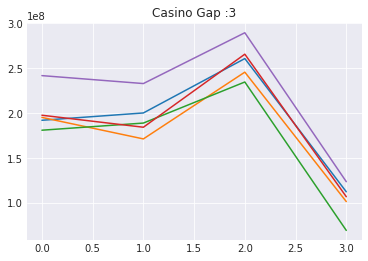

In [155]:
plotD(fullData, 3, 'EGM')
plotD(fullData, 3, 'Casino')

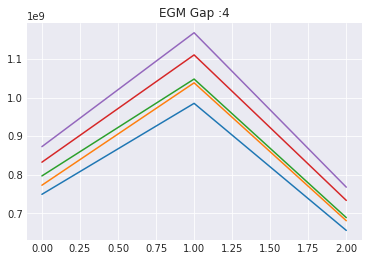

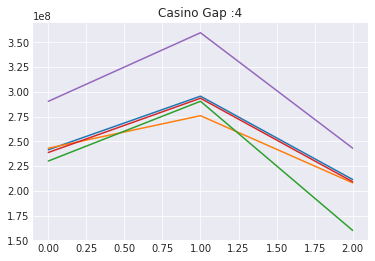

In [156]:
plotD(fullData, 4, 'EGM')
plotD(fullData, 4, 'Casino')

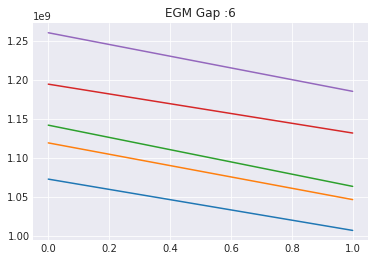

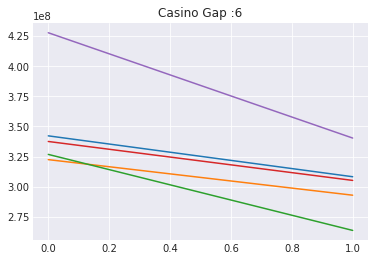

In [157]:
plotD(fullData, 6, 'EGM')
plotD(fullData, 6, 'Casino')

### 2. Seasaonal data analysis
April to July is Peak period for gambling Hence analysis only Summer data

In [76]:
def analysisOfSeasonal(data, start, end):
    SummerData = data[data['Month'] >= start]
    SummerData = data[data['Month'] <= end]
    scaledData = dataNormalization(SummerData)
    plotCorrelation(scaledData)
    analyzeCDFs(scaledData, ['Casino', 'EGM', 'Lottery', 'btc_total_bitcoins', 'btc_n_transactions_total', 'btc_per_month'])
    plt.plot(scaledData['btc_total_bitcoins'])
    plt.plot(scaledData['EGM'])
    plt.plot(scaledData['Casino'])
    plt.plot(scaledData['Lottery'])
    plt.plot(scaledData['btc_per_month'])
    plt.legend()  

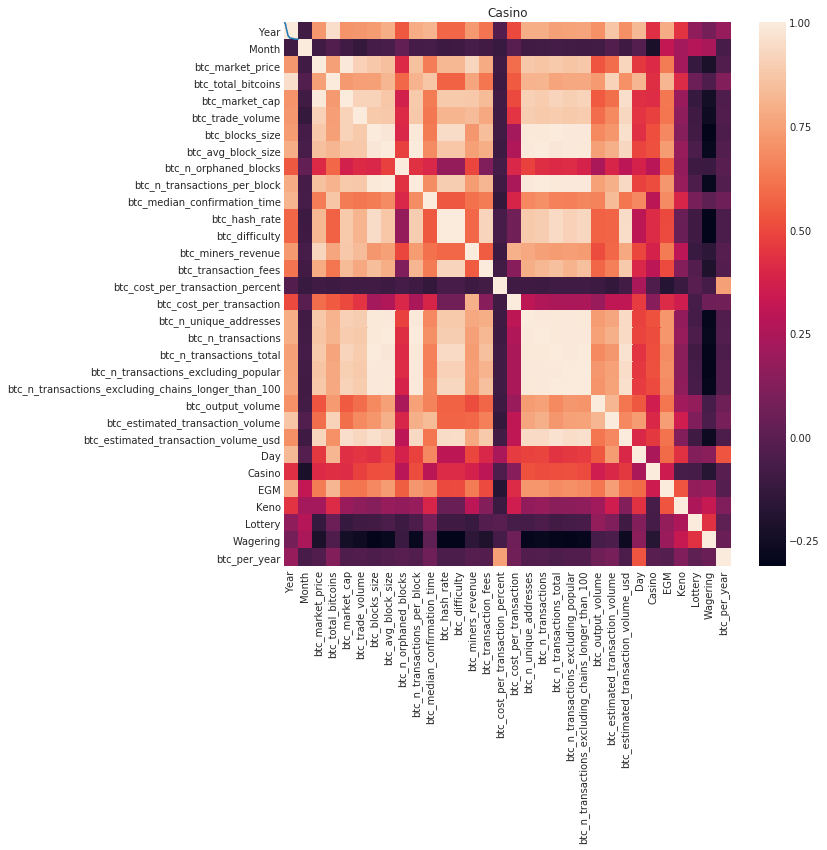

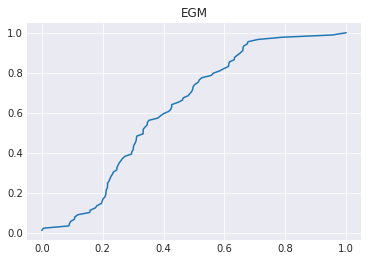

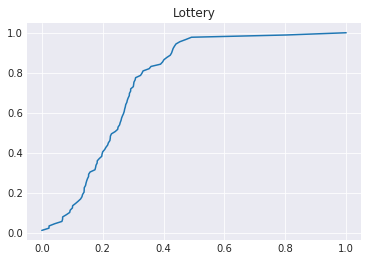

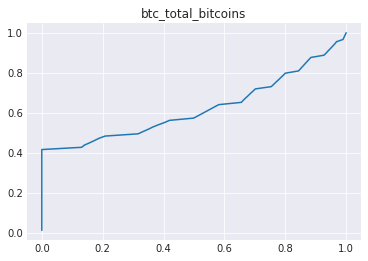

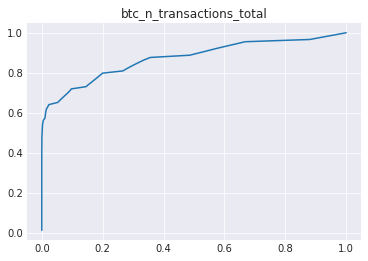

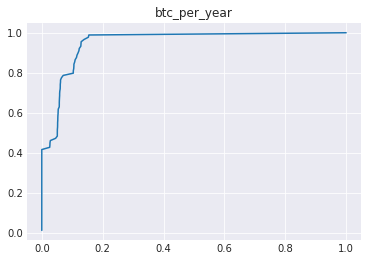

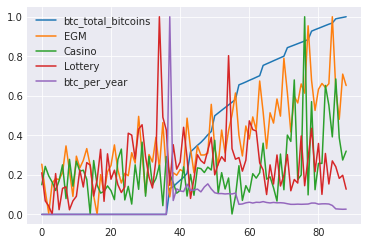

In [110]:
data = fullData #fullData[fullData['Year'] >= 2013]
analysisOfSeasonal(data, 4, 7)

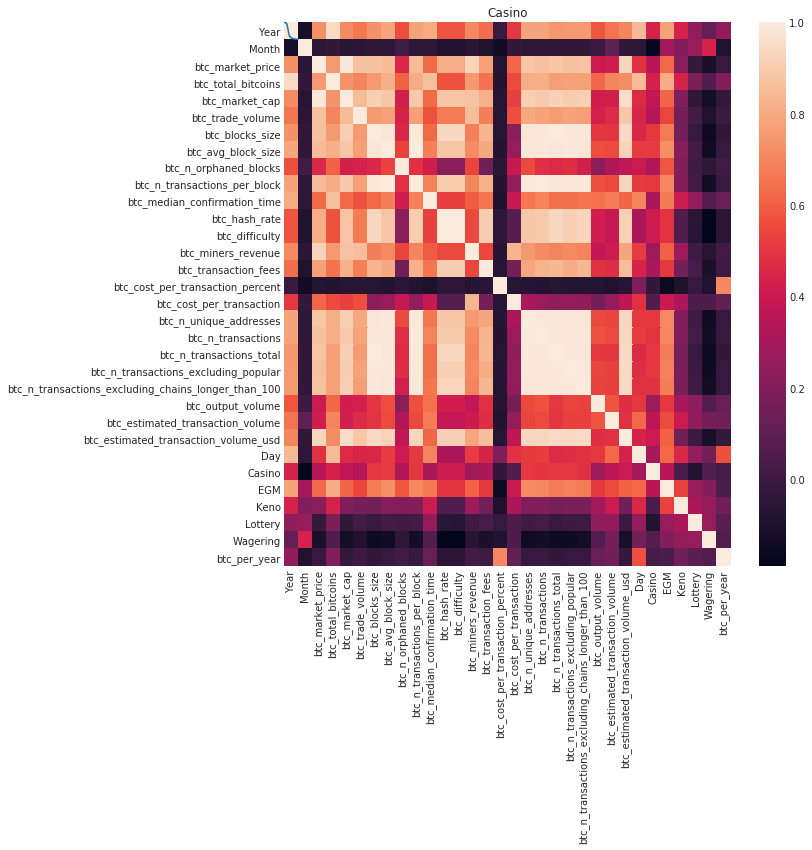

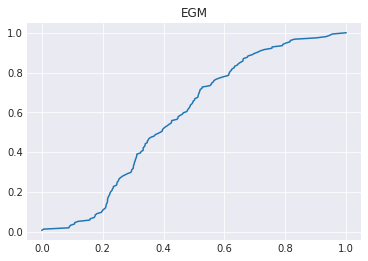

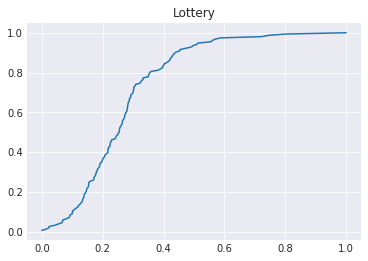

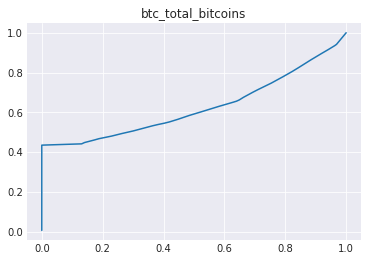

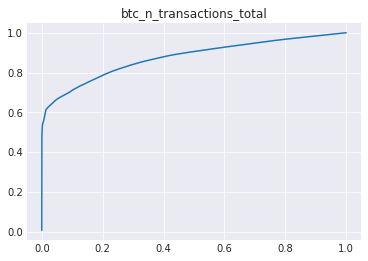

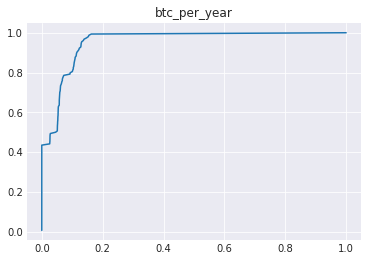

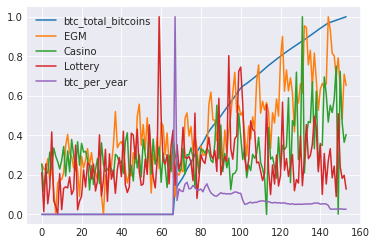

In [111]:
data = fullData #fullData[fullData['Year'] >= 2013]
analysisOfSeasonal(data, 1, 12)

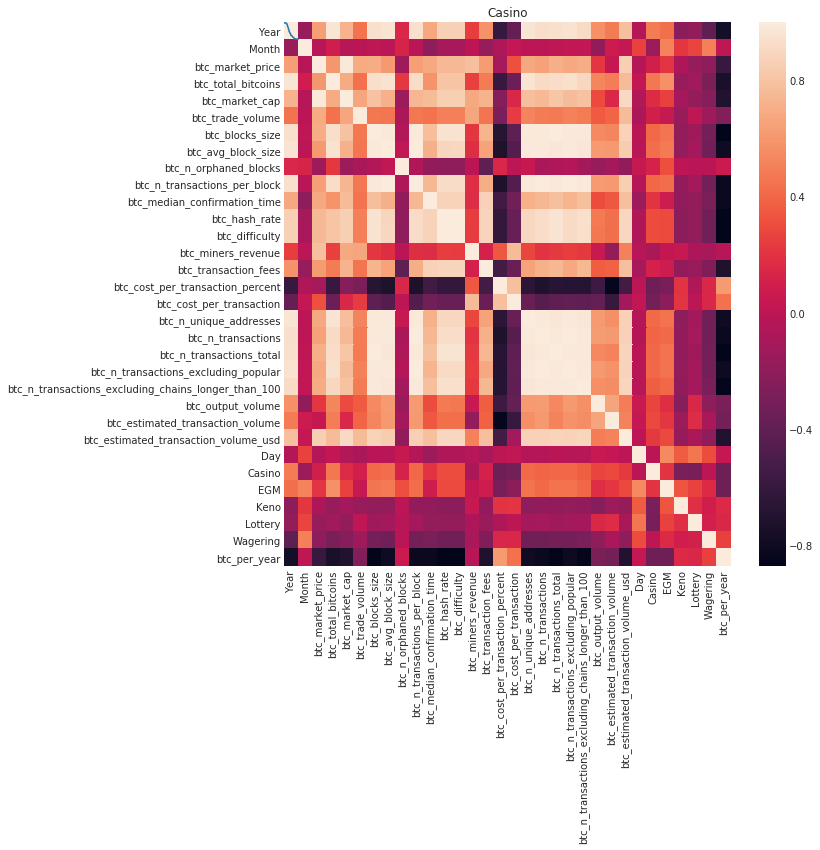

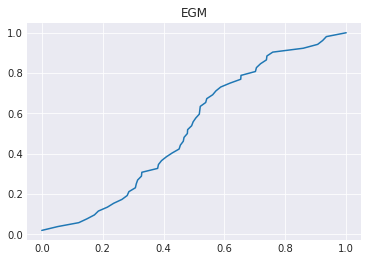

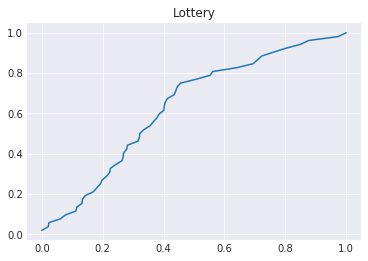

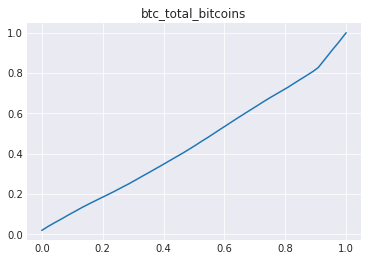

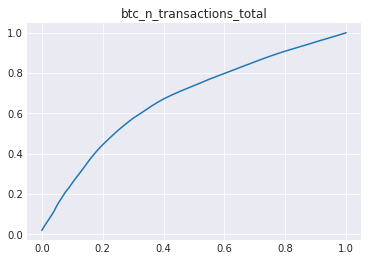

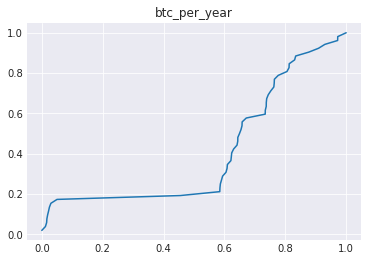

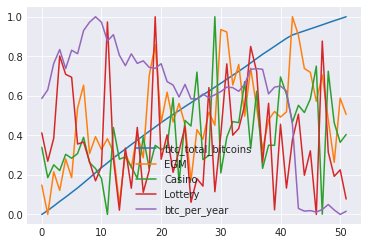

In [112]:
data = fullData[fullData['Year'] >= 2013]
analysisOfSeasonal(data, 1, 12)

### Analyis Year over Year

In [113]:
fData = pd.read_csv('./Data/Casino/ProcessedDataAll.csv')
nData = averageData(fData, ['Year'])
nData[:][:2]

Year     Month  btc_market_price  btc_total_bitcoins  btc_market_cap  \
0  2004  9.166667               0.0                 0.0             0.0   
1  2005  6.333333               0.0                 0.0             0.0   

   btc_trade_volume  btc_blocks_size  btc_avg_block_size  \
0               0.0              0.0                 0.0   
1               0.0              0.0                 0.0   

   btc_n_orphaned_blocks  btc_n_transactions_per_block      ...       \
0                    0.0                           0.0      ...        
1                    0.0                           0.0      ...        

   btc_output_volume  btc_estimated_transaction_volume  \
0                0.0                               0.0   
1                0.0                               0.0   

   btc_estimated_transaction_volume_usd  Day        Casino           EGM  \
0                                   0.0  0.0  4.357442e+07  1.439966e+08   
1                                   0.0  0.0  4.739821e+07  1.434488e+08   

           Keno       Lottery      Wagering  btc_per_year  
0  6.637830e+06  3.129293e+07  2.874819e+07           0.0  
1  7.364004e+06  2.912136e+07  2.807978e+07           0.0  

[2 rows x 32 columns]

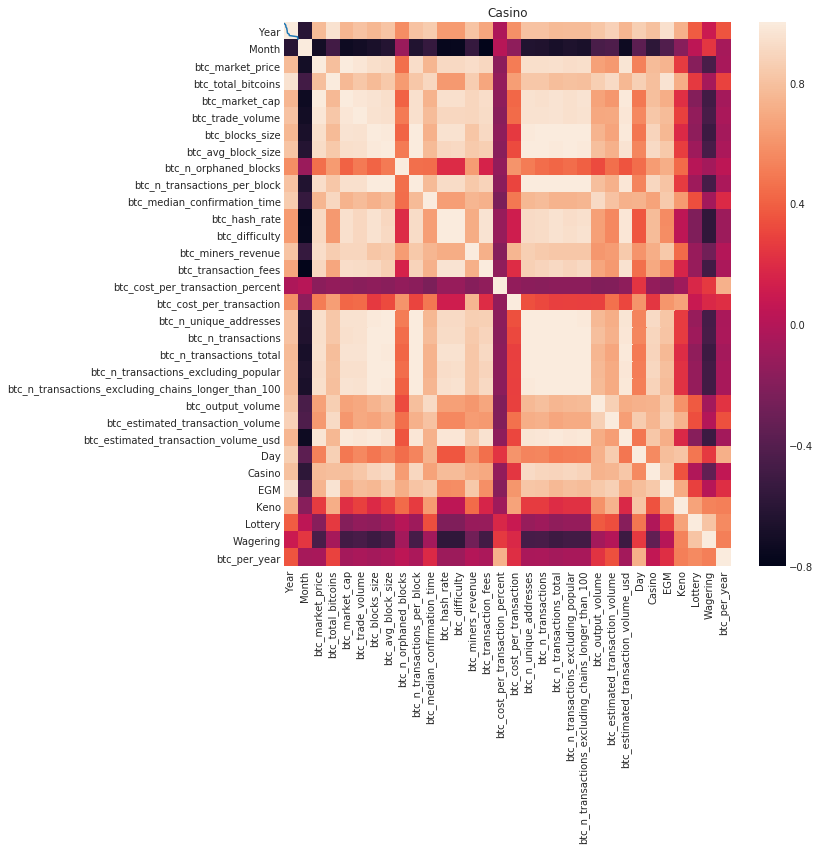

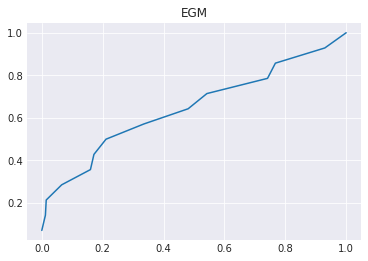

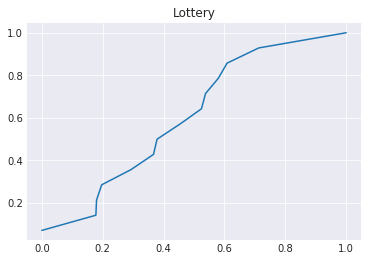

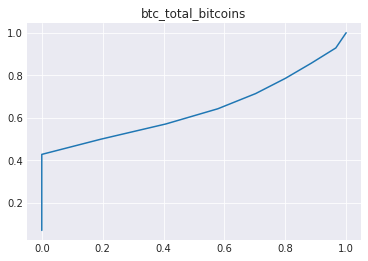

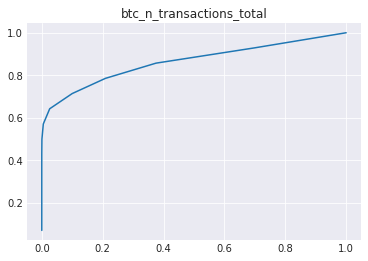

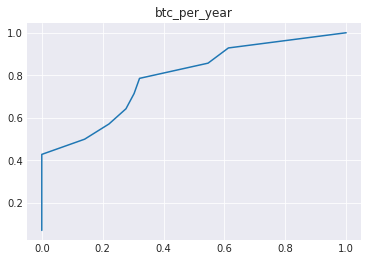

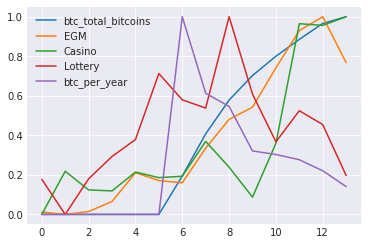

In [114]:
analysisOfSeasonal(nData, 1, 12)

In [115]:
# KS-Test for Year over Year
from scipy import stats
_, egmY = utils.plot_a(np.array(nData['EGM']))
_, casinoY = utils.plot_a(np.array(nData['Casino']))
_, tBTCP = utils.plot_a(np.array(nData['btc_market_price']))
_, tBTCY = utils.plot_a(np.array(nData['btc_total_bitcoins']))
_, tBTCY1 = utils.plot_a(np.array(nData['btc_per_month']))

print(stats.ks_2samp(egmY, tBTCP))
print(stats.ks_2samp(casinoY, tBTCP))
print(stats.ks_2samp(egmY, tBTCY))
print(stats.ks_2samp(casinoY, tBTCY))
print(stats.ks_2samp(egmY, tBTCY1))
print(stats.ks_2samp(casinoY, tBTCY1))

Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.0, pvalue=1.0)
Ks_2sampResult(statistic=0.0, pvalue=1.0)


In [116]:
fData = pd.read_csv('./Data/Casino/ProcessedDataAll.csv')
nData = averageData(fData, ['Year'])
nData[:][:2]

Year     Month  btc_market_price  btc_total_bitcoins  btc_market_cap  \
0  2004  9.166667               0.0                 0.0             0.0   
1  2005  6.333333               0.0                 0.0             0.0   

   btc_trade_volume  btc_blocks_size  btc_avg_block_size  \
0               0.0              0.0                 0.0   
1               0.0              0.0                 0.0   

   btc_n_orphaned_blocks  btc_n_transactions_per_block      ...       \
0                    0.0                           0.0      ...        
1                    0.0                           0.0      ...        

   btc_output_volume  btc_estimated_transaction_volume  \
0                0.0                               0.0   
1                0.0                               0.0   

   btc_estimated_transaction_volume_usd  Day        Casino           EGM  \
0                                   0.0  0.0  4.357442e+07  1.439966e+08   
1                                   0.0  0.0  4.739821e+07  1.434488e+08   

           Keno       Lottery      Wagering  btc_per_year  
0  6.637830e+06  3.129293e+07  2.874819e+07           0.0  
1  7.364004e+06  2.912136e+07  2.807978e+07           0.0  

[2 rows x 32 columns]

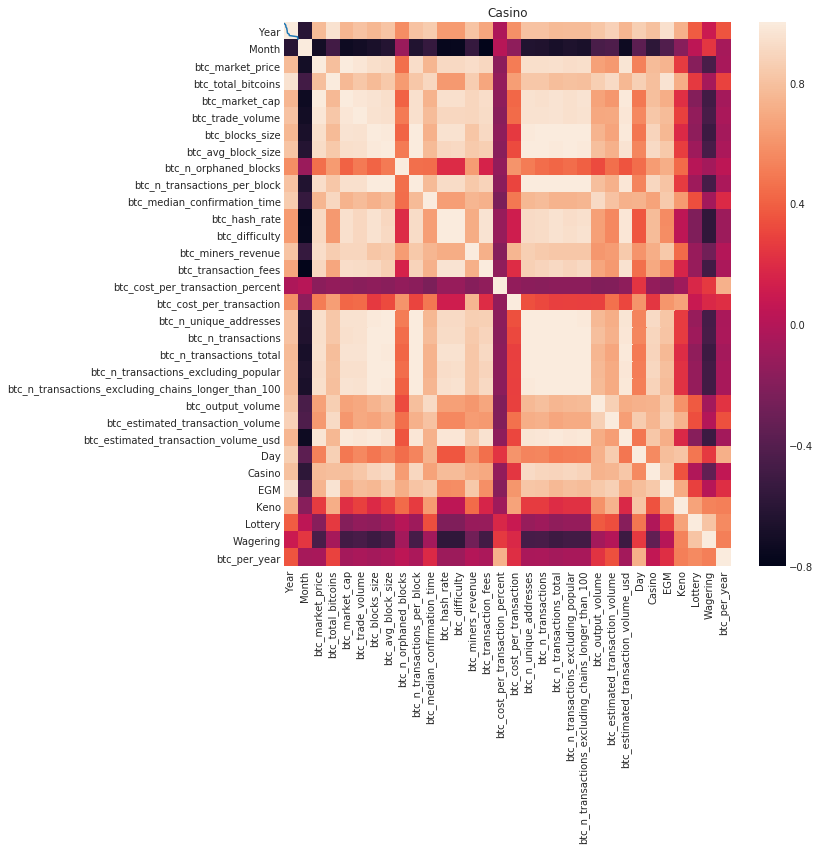

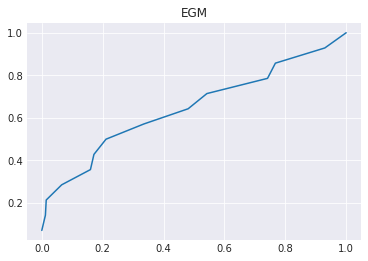

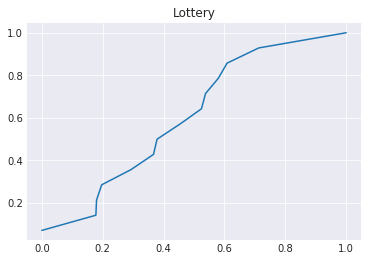

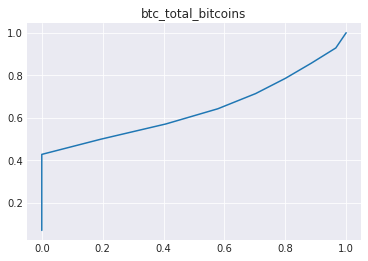

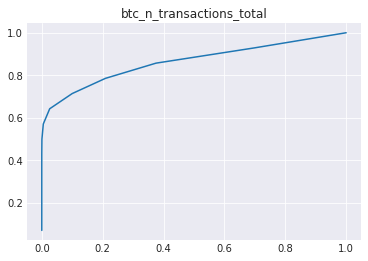

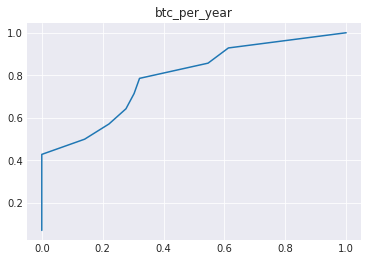

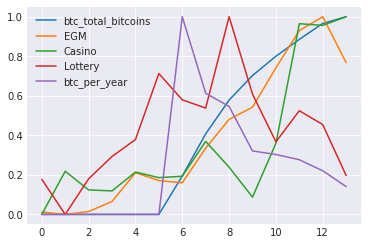

In [117]:
analysisOfSeasonal(nData, 1, 12)

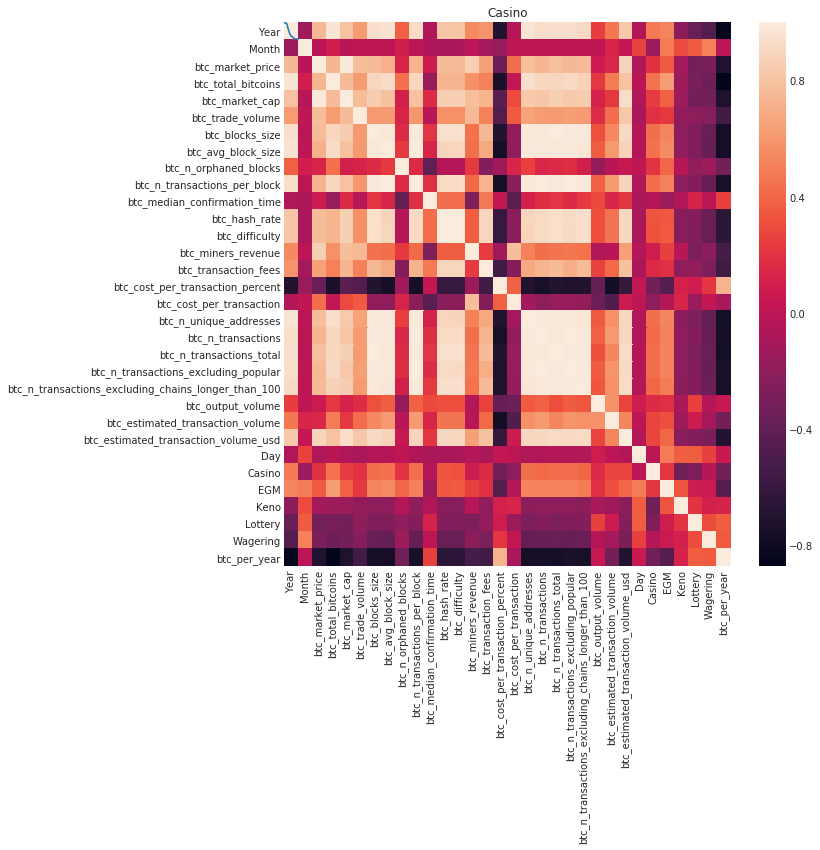

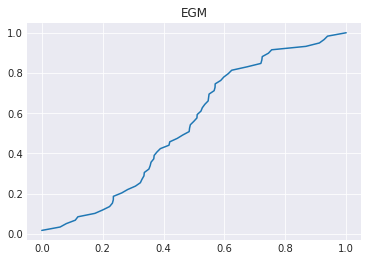

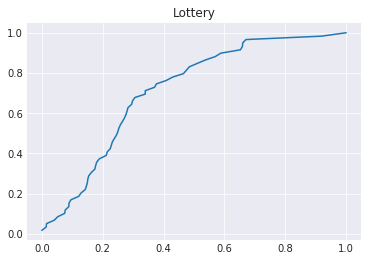

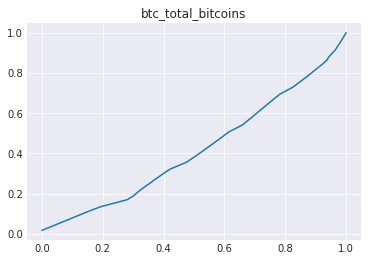

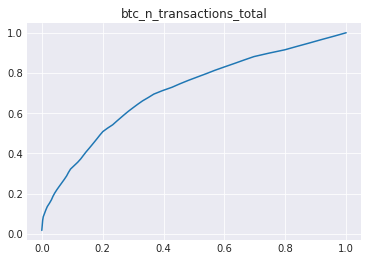

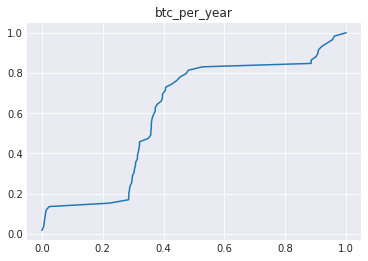

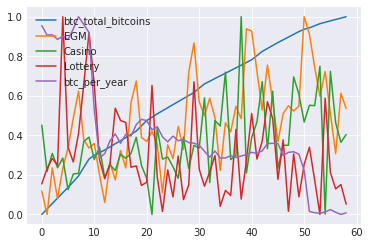

In [144]:
# Monthly Analysis
fData = pd.read_csv('./Data/Casino/ProcessedDataAll.csv')
fData = fData[fData['Year'] >= 2012]
nData = averageData(fData, ['Year', 'Month'])
analysisOfSeasonal(nData, 1, 12)

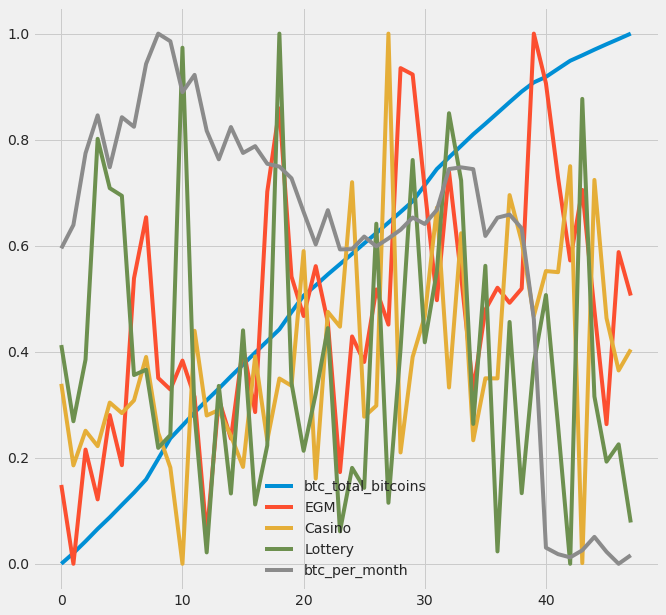

In [216]:
# Monthly Analysis
fData = pd.read_csv('./Data/Casino/ProcessedDataAll.csv')
fData = fData[fData['Year'] >= 2013]
nData = averageData(fData, ['Year', 'Month'])
analysisOfSeasonal(nData, 1, 12)

In [120]:
print(stats.kstest(np.array(nData['Casino']),'norm', mode='asymp'))
print(stats.kstest(np.array(nData['EGM']),'norm', mode='asymp'))
print(stats.kstest(np.array(nData['btc_per_month']),'norm', mode='asymp'))
print(stats.kstest(np.array(nData['btc_total_bitcoins']),'norm', mode='asymp'))

KstestResult(statistic=1.0, pvalue=4.06218532546968e-42)
KstestResult(statistic=1.0, pvalue=4.06218532546968e-42)
KstestResult(statistic=1.0, pvalue=4.06218532546968e-42)
KstestResult(statistic=1.0, pvalue=4.06218532546968e-42)


In [147]:
sData = dataNormalization(nData)
runTests(np.array(sData['Casino']), np.array(sData['btc_per_month']), 'Casino and Yearly Bitcoins')
runTests(np.array(sData['EGM']), np.array(sData['btc_per_month']), 'EGM and BitCoin Price')
runTests(np.array(sData['Lottery']), np.array(sData['btc_per_month']), 'Lottery and BitCoin Price')
runTests(np.array(sData['Keno']), np.array(sData['btc_per_month']), 'Keno and BitCoin Price')
runTests(np.array(sData['Wagering']), np.array(sData['btc_per_month']), 'Wagering and BitCoin Price')

== Running Tests for Casino and Yearly Bitcoins ==
0.8477437699835663
Accept Null
P-Value: 0.396580684475
CI: [-0.04732424618789166, 0.11946380143113078] 
P-Val of P-Test: 0.40265
== Running Tests for EGM and BitCoin Price ==
1.3545976551439924
Accept Null
P-Value: 0.175545780972
CI: [-0.027686649572338018, 0.15158531269496844] 
P-Val of P-Test: 0.18022
== Running Tests for Lottery and BitCoin Price ==
2.3957541817967143
Reject Null
P-Value: 0.016586209675
CI: [0.019460444587807033, 0.19452461142990873] 
P-Val of P-Test: 0.01854
== Running Tests for Keno and BitCoin Price ==
2.7283674572952727
Reject Null
P-Value: 0.00636486628317
CI: [0.037573944630184875, 0.22926590340834446] 
P-Val of P-Test: 0.00827
== Running Tests for Wagering and BitCoin Price ==
0.8319677287605489
Accept Null
P-Value: 0.405427160255
CI: [-0.04924247586955509, 0.12187896305573319] 
P-Val of P-Test: 0.4111


In [191]:
sData = dataNormalization(nData)
runTests(np.array(sData['Casino']), np.array(sData['btc_market_price']), 'Casino and Yearly Bitcoins')
runTests(np.array(sData['EGM']), np.array(sData['btc_market_price']), 'EGM and BitCoin Price')
runTests(np.array(sData['Lottery']), np.array(sData['btc_market_price']), 'Lottery and BitCoin Price')
runTests(np.array(sData['Keno']), np.array(sData['btc_market_price']), 'Keno and BitCoin Price')
runTests(np.array(sData['Wagering']), np.array(sData['btc_market_price']), 'Wagering and BitCoin Price')

== Running Tests for Casino and Yearly Bitcoins ==
0.6468482743209202
Accept Null
P-Value: 0.517730145554
CI: [-0.058619865870751825, 0.11637124118849848] 
P-Val of P-Test: 0.52531
== Running Tests for EGM and BitCoin Price ==
2.401341527729256
Reject Null
P-Value: 0.0163350827248
CI: [0.02120497188150433, 0.20954775077923288] 
P-Val of P-Test: 0.01962
== Running Tests for Lottery and BitCoin Price ==
0.4812131360453207
Accept Null
P-Value: 0.630365025698
CI: [-0.07496203650903495, 0.12374894089955442] 
P-Val of P-Test: 0.63662
== Running Tests for Keno and BitCoin Price ==
3.283927382788058
Reject Null
P-Value: 0.00102371296205
CI: [0.06769315410266233, 0.2681249659469198] 
P-Val of P-Test: 0.0017
== Running Tests for Wagering and BitCoin Price ==
0.433740349038257
Accept Null
P-Value: 0.664477002749
CI: [-0.06789634985554258, 0.10648662047720212] 
P-Val of P-Test: 0.67056


## Linear regression

In [211]:
def getSSE(Y, YPredict):
    return np.sum((YPredict - Y)**2)

# Iterative Implementation of MAPE
def getMAPE(Y, YPredict):
    tSum = 0.0
    count = np.count_nonzero(Y)
    for i in range(0, len(Y)):
        if Y[i] != 0:
            tSum += np.asscalar(np.abs((Y[i] - YPredict[i])/Y[i]))
    tSum = tSum * 100 / count #len(Y)
    return tSum

def linearRegression(sData, xFields, yField): 
    sData = sData.sample(frac=1)
    trainX = np.array(sData[xFields][:50])
    trainY = np.array(sData[yField][:50])
    testX = np.array(sData[xFields][-9:])
    testY = np.array(sData[yField][-9:])

    regr = linear_model.LinearRegression()
    regr.fit(trainX, trainY)
    print('Coefficients: \n', regr.coef_)
    return regr, testX, testY

def predict(regr, testX, testY):
    predY = regr.predict(testX)
    print("Mean squared error: %.2f"
          % mean_squared_error(testY, predY))
    print('Variance score: %.2f' % r2_score(testY, predY))
    return predY

def errors(trueY, predY):
    print('SSE:', getSSE(predY, trueY))
    print('MAPE:', getMAPE(predY, trueY))
    
def plot(testX, testY, predY, label, xLabel, yLabel, show = True):
    plt.style.use('fivethirtyeight')
    plt.figure(figsize=(10,6))
    plt.scatter(testX, testY,  label = 'Original Data')
    plt.plot(testX, predY, color = 'red', label = 'Prediction')
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.legend()
    plt.title(label)
    if show:
        plt.show()
    else:
        plt.savefig(label, bbox_inches="tight")
        plt.clf()
    

('Coefficients: \n', array([-0.47494247]))
Mean squared error: 0.02
Variance score: -0.11
('SSE:', 0.17757866162810612)
('MAPE:', 27.599554362084685)


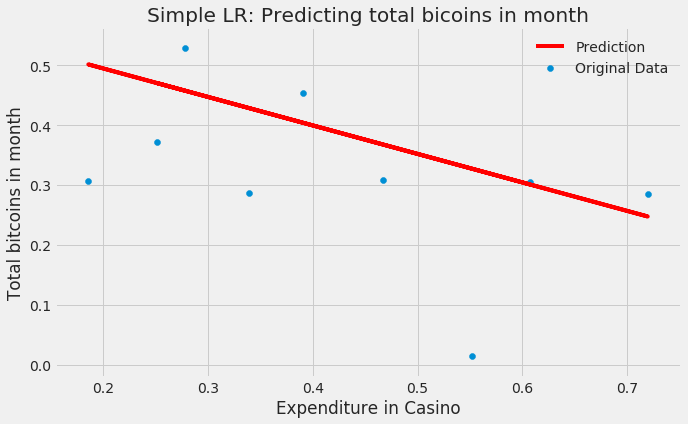

In [250]:
fData = pd.read_csv('./Data/Casino/ProcessedDataAll.csv')
fData = fData[fData['Year'] >= 2012]
nData = averageData(fData, ['Year', 'Month'])
sData = dataNormalization(nData)
rgr, tX, tY = linearRegression(sData, ['Casino'], 'btc_per_month')
pY = predict(rgr, tX, tY)
errors(tY, pY)
plot(tX, tY, pY, 'Simple LR: Predicting total bicoins in month', 'Expenditure in Casino', 'Total bitcoins in month') #, show = False)

In [251]:
plot(tX, tY, pY, 'Simple LR: Predicting total bicoins in month', 'Expenditure in Casino', 'Total bitcoins in month', show = False)

<Figure size 720x432 with 0 Axes>

('Coefficients: \n', array([0.38148473]))
Mean squared error: 0.11
Variance score: 0.10
('SSE:', 1.0202410201186716)
('MAPE:', 50.313238160926694)


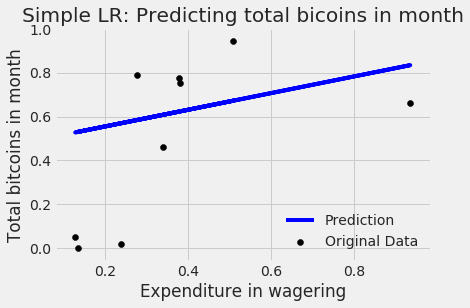

In [160]:
sData = dataNormalization(nData)
rgr, tX, tY = linearRegression(sData, ['Wagering'], 'btc_per_month')
pY = predict(rgr, tX, tY)
errors(tY, pY)
plot(tX, tY, pY, "Simple LR: Predicting total bicoins in month", 'Expenditure in wagering', 'Total bitcoins in month') #show = False)

('Coefficients: \n', array([0.10022565]))
Mean squared error: 0.04
Variance score: -0.09
('SSE:', 0.3981121129354025)
('MAPE:', 52.80583892634838)


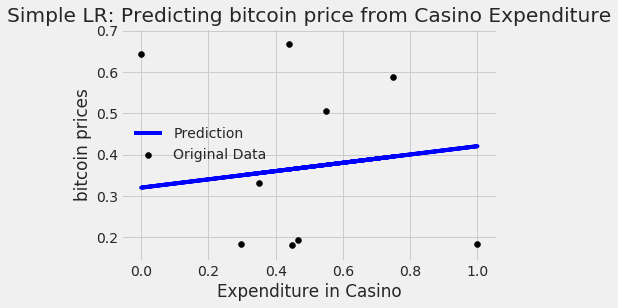

In [159]:
rgr, tX, tY = linearRegression(sData, ['Casino'], 'btc_market_price')
pY = predict(rgr, tX, tY)
errors(tY, pY)
plot(tX, tY, pY, 'Simple LR: Predicting bitcoin price from Casino Expenditure', 'Expenditure in Casino', 'bitcoin prices') #show = False)

('Coefficients: \n', array([-0.22572717]))
Mean squared error: 0.04
Variance score: -0.17
('SSE:', 0.3396555831166161)
('MAPE:', 45.37681382492633)


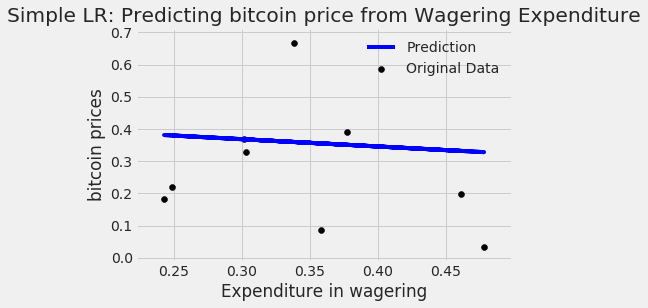

In [158]:
rgr, tX, tY = linearRegression(sData, ['Wagering'], 'btc_market_price')
pY = predict(rgr, tX, tY)
errors(tY, pY)
plot(tX, tY, pY, 'Simple LR: Predicting bitcoin price from Wagering Expenditure', 'Expenditure in wagering', 'bitcoin prices') #show = False)

### Running LR on full data

('Coefficients: \n', array([0.59916959]))
Mean squared error: 0.05
Variance score: -0.06
('SSE:', 0.46534344633497365)
('MAPE:', 42.40989826721935)


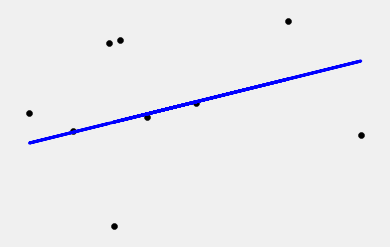

In [107]:
lr, tX, tY = linearRegression(sData, ['Casino'], 'btc_n_unique_addresses')
pY = predict(lr, tX, tY)
errors(tY, pY)
plot(tX, tY, pY)

In [94]:
mlr, tX, tY = linearRegression(sData, ['EGM', 'Casino', 'Keno', 'Lottery', 'Wagering'], 'btc_per_month')
pY = predict(mlr, tX, tY)
errors(tY, pY)

('Coefficients: \n', array([-0.61719227, -0.12118686,  0.29498275,  0.21128635,  0.42335204]))
Mean squared error: 0.06
Variance score: -0.17
('SSE:', 0.5503847529434441)
('MAPE:', 35.46541673303951)


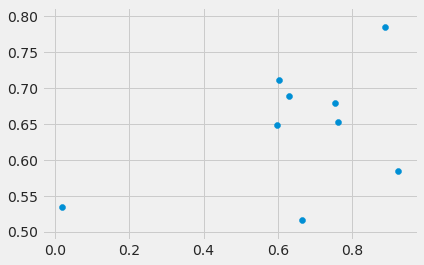

In [192]:
plt.scatter(tY, pY)
#plt.scatter(tY, c="g", alpha=0.5, marker=r'$\clubsuit$', label="Luck")

('Coefficients: \n', array([ 0.43326647, -0.17935857, -0.21264122, -0.24882613, -0.23675503]))
Mean squared error: 0.04
Variance score: 0.17
('SSE:', 0.37675689866364526)
('MAPE:', 61.085067637487704)


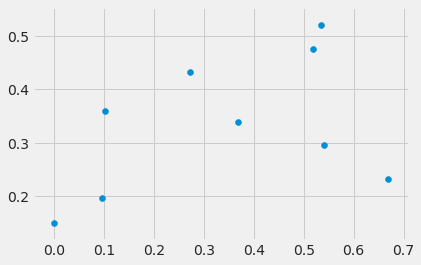

In [193]:
mlr, tX, tY = linearRegression(sData, ['EGM', 'Casino', 'Keno', 'Lottery', 'Wagering'], 'btc_market_price')
pY = predict(mlr, tX, tY)
errors(tY, pY)
plt.scatter(tY, pY)

### Analysis with >= 2012 

In [4]:
fData = pd.read_csv('./Data/Casino/ProcessedDataAll.csv')
fData = fData[fData['Year'] >= 2012]
nData = analysis.averageData(fData, ['Year', 'Month'])

In [9]:
sData = dataNormalization(nData)
runTests(np.array(sData['Casino']), np.array(sData['btc_per_month']), 'Casino and Yearly Bitcoins')
runTests(np.array(sData['EGM']), np.array(sData['btc_per_month']), 'EGM and BitCoin Price')
runTests(np.array(sData['Lottery']), np.array(sData['btc_per_month']), 'Lottery and BitCoin Price')
runTests(np.array(sData['Keno']), np.array(sData['btc_per_month']), 'Keno and BitCoin Price')
runTests(np.array(sData['Wagering']), np.array(sData['btc_per_month']), 'Wagering and BitCoin Price')

== Running Tests for Casino and Yearly Bitcoins ==
0.8477437699835663
Accept Null
P-Value: 0.396580684475
CI: [-0.04732424618789166, 0.11946380143113078] 
P-Val of P-Test: 0.40261
== Running Tests for EGM and BitCoin Price ==
1.3545976551439924
Accept Null
P-Value: 0.175545780972
CI: [-0.027686649572338018, 0.15158531269496844] 
P-Val of P-Test: 0.18269
== Running Tests for Lottery and BitCoin Price ==
2.3957541817967143
Reject Null
P-Value: 0.016586209675
CI: [0.019460444587807033, 0.19452461142990873] 
P-Val of P-Test: 0.01902
== Running Tests for Keno and BitCoin Price ==
2.7283674572952727
Reject Null
P-Value: 0.00636486628317
CI: [0.037573944630184875, 0.22926590340834446] 
P-Val of P-Test: 0.00773
== Running Tests for Wagering and BitCoin Price ==
0.8319677287605489
Accept Null
P-Value: 0.405427160255
CI: [-0.04924247586955509, 0.12187896305573319] 
P-Val of P-Test: 0.41237


In [10]:
sData = dataNormalization(nData)
runTests(np.array(sData['Casino']), np.array(sData['btc_market_price']), 'Casino and Yearly Bitcoins')
runTests(np.array(sData['EGM']), np.array(sData['btc_market_price']), 'EGM and BitCoin Price')
runTests(np.array(sData['Lottery']), np.array(sData['btc_market_price']), 'Lottery and BitCoin Price')
runTests(np.array(sData['Keno']), np.array(sData['btc_market_price']), 'Keno and BitCoin Price')
runTests(np.array(sData['Wagering']), np.array(sData['btc_market_price']), 'Wagering and BitCoin Price')

== Running Tests for Casino and Yearly Bitcoins ==
1.7092907963161525
Accept Null
P-Value: 0.0873970973073
CI: [-0.010335178906164075, 0.15126200506978804] 
P-Val of P-Test: 0.09182
== Running Tests for EGM and BitCoin Price ==
3.7858429363679993
Reject Null
P-Value: 0.000153188412512
CI: [0.08125604478290217, 0.25570899974659134] 
P-Val of P-Test: 0.00029
== Running Tests for Lottery and BitCoin Price ==
0.01058393263175036
Accept Null
P-Value: 0.991555401221
CI: [-0.08460366809720393, 0.08552234270805664] 
P-Val of P-Test: 0.99144
== Running Tests for Keno and BitCoin Price ==
5.02484822097148
Reject Null
P-Value: 5.03830839679e-07
CI: [0.14635663495368986, 0.3335495944917025] 
P-Val of P-Test: 0.0
== Running Tests for Wagering and BitCoin Price ==
1.657428102196329
Accept Null
P-Value: 0.0974329537266
CI: [-0.01281809435547035, 0.15324798857615532] 
P-Val of P-Test: 0.10383


In [74]:
lr, tX, tY = linearRegression(sData, ['EGM', 'Casino', 'Keno', 'Lottery', 'Wagering'], 'btc_per_month')

('Coefficients: \n', array([-0.51423409, -0.17076169,  0.10573616,  0.26921101,  0.43338779]))


In [66]:
linearRegression(sData, ['EGM', 'Casino', 'Keno', 'Lottery', 'Wagering'], 'btc_market_price')

('Coefficients: \n', array([ 0.50118528, -0.03297784, -0.13180716, -0.31446368, -0.24676772]))


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 array([[0.48548906, 0.20447403, 0.83368456, 0.26527817, 0.43674217],
        [0.48421973, 1.        , 0.36284785, 0.07713034, 0.24263556],
        [0.61273079, 0.3646574 , 0.44926129, 0.15110257, 0.13478218],
        [0.71983893, 0.23281472, 0.93226819, 0.14966144, 0.37952894],
        [0.35886157, 0.27769256, 0.83773443, 0.66009611, 0.51236857],
        [0.33686536, 0.12522789, 0.83153893, 0.34003088, 0.51287606],
        [0.93885125, 0.20997825, 0.82894166, 0.27157452, 0.24860365],
        [0.74470246, 0.55003585, 0.44130895, 0.17441031, 0.35475345],
        [0.26270272, 0.250927  , 0.72086829, 0.25825125, 0.47832705]]),
 array([2.54585770e-03, 1.90930417e-01, 9.24129607e-01, 5.04936299e-01,
        6.96127021e-03, 8.93372191e-04, 2.25958025e-01, 5.09372420e-01,
        4.32869137e-02]))

### Before and After 2013

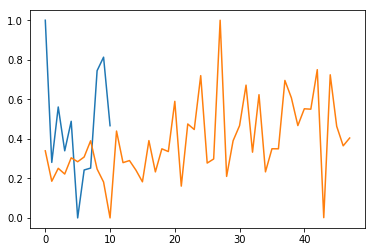

In [46]:
before = nData[nData['Year'] < 2013]
after = nData[nData['Year'] >= 2013]

bData = dataNormalization(before)
aData = dataNormalization(after)
plt.plot(bData['Casino'])
plt.plot(aData['Casino'])
plt.show()